# 0. Load dependencies

In [627]:
import pandas as pd 
import numpy as np
import os

from get_regression_coefs import get_regression_coefs

import matplotlib.pyplot as plt

# 1. Data cleaning and preprocessing 

First, we will load the data and filter it to include only observations for our target country, Brazil.

In [628]:
# Load the Penn World Table (PWT) dataset from an Excel file, specifically from the 'Data' sheet
df = pd.read_excel('pwt100.xlsx', sheet_name='Data')

# Filter the dataset to include only observations for Brazil ('BRA'),
# ensuring that all subsequent analyses focus solely on this country
df = df[df['countrycode'] == 'BRA']

# Reset the index after subsetting to maintain a clean, sequential index
# and drop the old index to avoid unnecessary columns
df = df.reset_index(drop=True)

In [629]:
df

,countrycode,country,currency_unit,year,rgdpe,rgdpo,pop,emp,avh,hc,...,csh_x,csh_m,csh_r,pl_c,pl_i,pl_g,pl_x,pl_m,pl_n,pl_k
0,BRA,Brazil,Brazilian Real,1950,9.187195e+04,8.844267e+04,53.124132,16.988243,2042.000000,1.300444,...,0.117741,-0.114157,1.270866e-02,0.158192,0.117806,0.140722,0.141141,0.103878,0.080012,NaN
1,BRA,Brazil,Brazilian Real,1951,9.601211e+04,9.110038e+04,54.667327,17.461807,2051.018631,1.308093,...,0.134638,-0.187441,9.603065e-03,0.180773,0.133821,0.153916,0.156691,0.112460,0.094750,NaN
2,BRA,Brazil,Brazilian Real,1952,1.049840e+05,1.007701e+05,56.264762,17.952208,2060.077094,1.315788,...,0.087728,-0.140368,2.241826e-02,0.208832,0.137821,0.172702,0.174585,0.131739,0.099380,NaN
3,BRA,Brazil,Brazilian Real,1953,1.079460e+05,1.041409e+05,57.918632,18.460180,2069.175564,1.323528,...,0.088722,-0.091622,1.472119e-02,0.211535,0.164786,0.182568,0.184702,0.129070,0.118297,NaN
4,BRA,Brazil,Brazilian Real,1954,1.176132e+05,1.130284e+05,59.631212,18.986502,2078.314218,1.331313,...,0.091111,-0.108842,1.277855e-03,0.163286,0.146506,0.145203,0.156026,0.113482,0.104388,2.597880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,BRA,Brazil,Brazilian Real,2015,3.082948e+06,3.082939e+06,204.471769,92.447227,1722.875805,2.813660,...,0.120297,-0.132928,1.291916e-16,0.585604,0.524357,0.659558,0.629805,0.620915,0.344669,0.558301
66,BRA,Brazil,Brazilian Real,2016,2.939546e+06,2.931514e+06,206.163053,90.626472,1714.675028,2.880657,...,0.123180,-0.121306,0.000000e+00,0.615286,0.543460,0.673155,0.622626,0.611971,0.355176,0.567208
67,BRA,Brazil,Brazilian Real,2017,2.970571e+06,2.968826e+06,207.833823,90.501389,1709.594351,2.949250,...,0.137065,-0.130464,-1.128691e-16,0.705088,0.599058,0.744396,0.634841,0.628697,0.397886,0.645436
68,BRA,Brazil,Brazilian Real,2018,3.057742e+06,3.042122e+06,209.469323,92.090942,1706.057169,3.019475,...,0.140989,-0.140941,1.234868e-16,0.620447,0.545390,0.670433,0.654160,0.637610,0.368352,0.562399


We also check for missing values for the variables of interest and are able to confirm that there are no missing values.

In [630]:
# check missing values for the variables of interest
df[['year', 'pop', 'emp', 'hc', 'rgdpna', 'rnna']].isnull().sum()

year      0
pop       0
emp       0
hc        0
rgdpna    0
rnna      0
dtype: int64

Next, we will create new variables for use in the analysis:  
- ```"rgdpna_pc"```: Real GDP per capita, in constant 2017 national prices 
- ```"log_rgdpna"```: Natural logarithm of real GDP
- ```"log_rgdpna_pc"```: Natural logarithm of real GDP per capita  

In [631]:
# Compute real GDP per capita by dividing total real GDP ('rgdpna') by population ('pop')
df["rgdpna_pc"] = df["rgdpna"] / df["pop"]

# Take the natural logarithm of total real GDP ('rgdpna') to linearise growth trends
df["log_rgdpna"] = np.log(df["rgdpna"])

# Take the natural logarithm of real GDP per capita ('rgdpna_pc') for similar reasons
df["log_rgdpna_pc"] = np.log(df["rgdpna_pc"])

Before we start fitting trend time paths, it is useful to plot the data to get a sense of the relationship between the variables of interest. We first plot real GDP and real GDP per capita against time to check the trend in the data.   

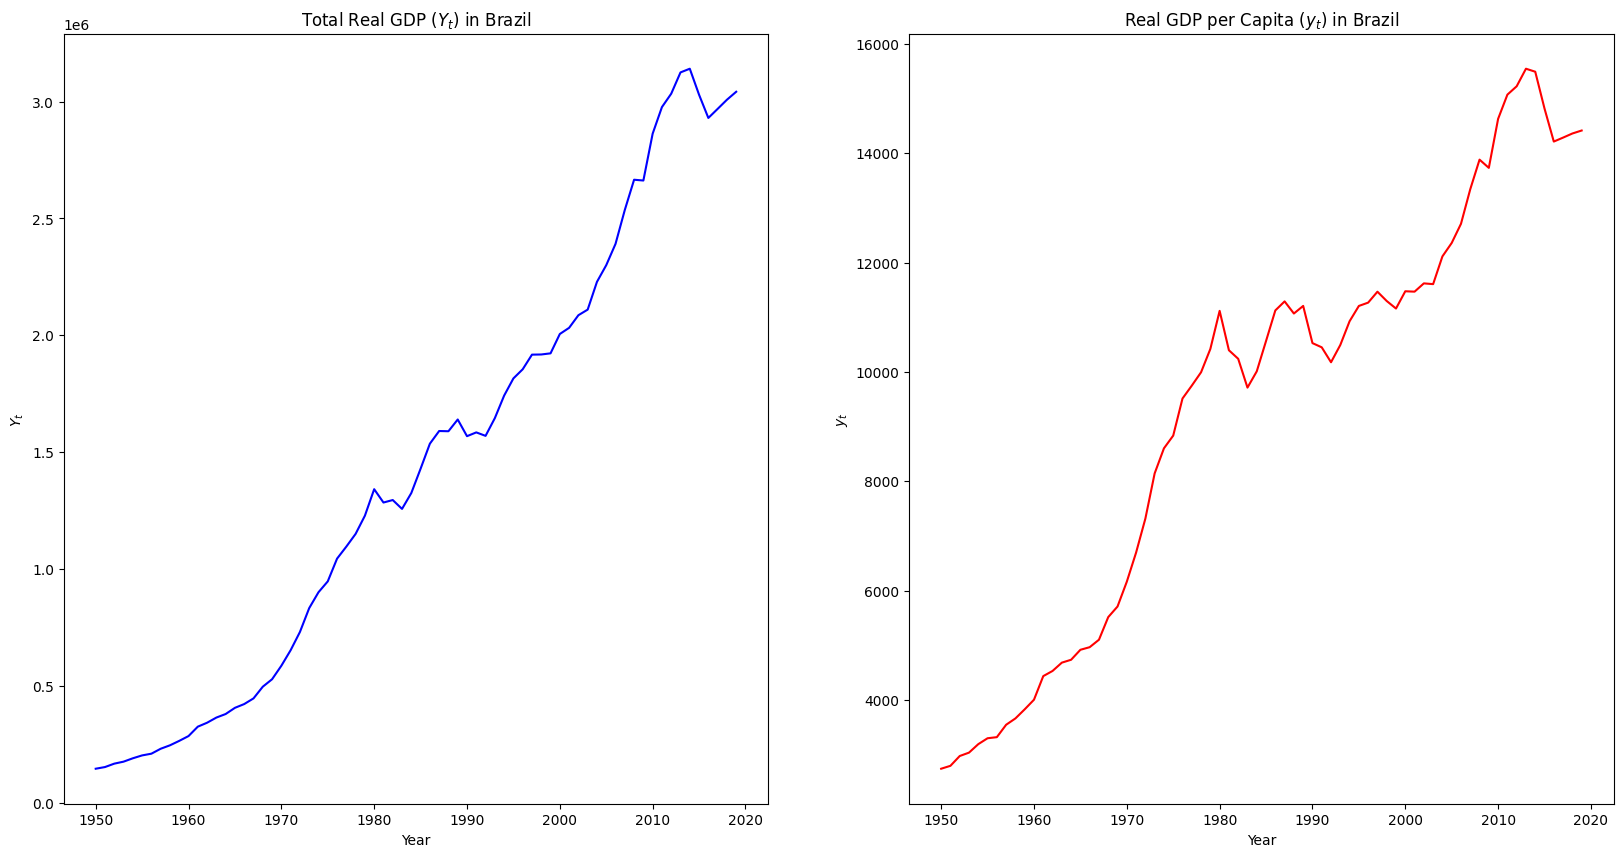

In [632]:
# plot two panels: one for total real GDP and one for real GDP per capita
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# plot total real GDP
ax[0].plot(df["year"], df["rgdpna"], color='blue')
ax[0].set_title(r'Total Real GDP ($Y_t$) in Brazil')
ax[0].set_xlabel("Year")
ax[0].set_ylabel("$Y_t$")

# plot real GDP per capita
ax[1].plot(df["year"], df["rgdpna_pc"], color='red')
ax[1].set_title(r'Real GDP per Capita ($y_t$) in Brazil')
ax[1].set_xlabel("Year")
ax[1].set_ylabel("$y_t$")

# save the plot
plt.savefig(os.path.join('plots', 'real_gdp_and_real_gdp_per_capita.png'), dpi=300, bbox_inches='tight') 

plt.show()



The plot shows that real GDP has been increasing exponentially over time. As for real GDP per capita, it has been increasing over time, but the trend is not as clear as for real GDP. Linearising the data by taking the natural logarithm of real GDP and real GDP per capita will help us better understand the trend.

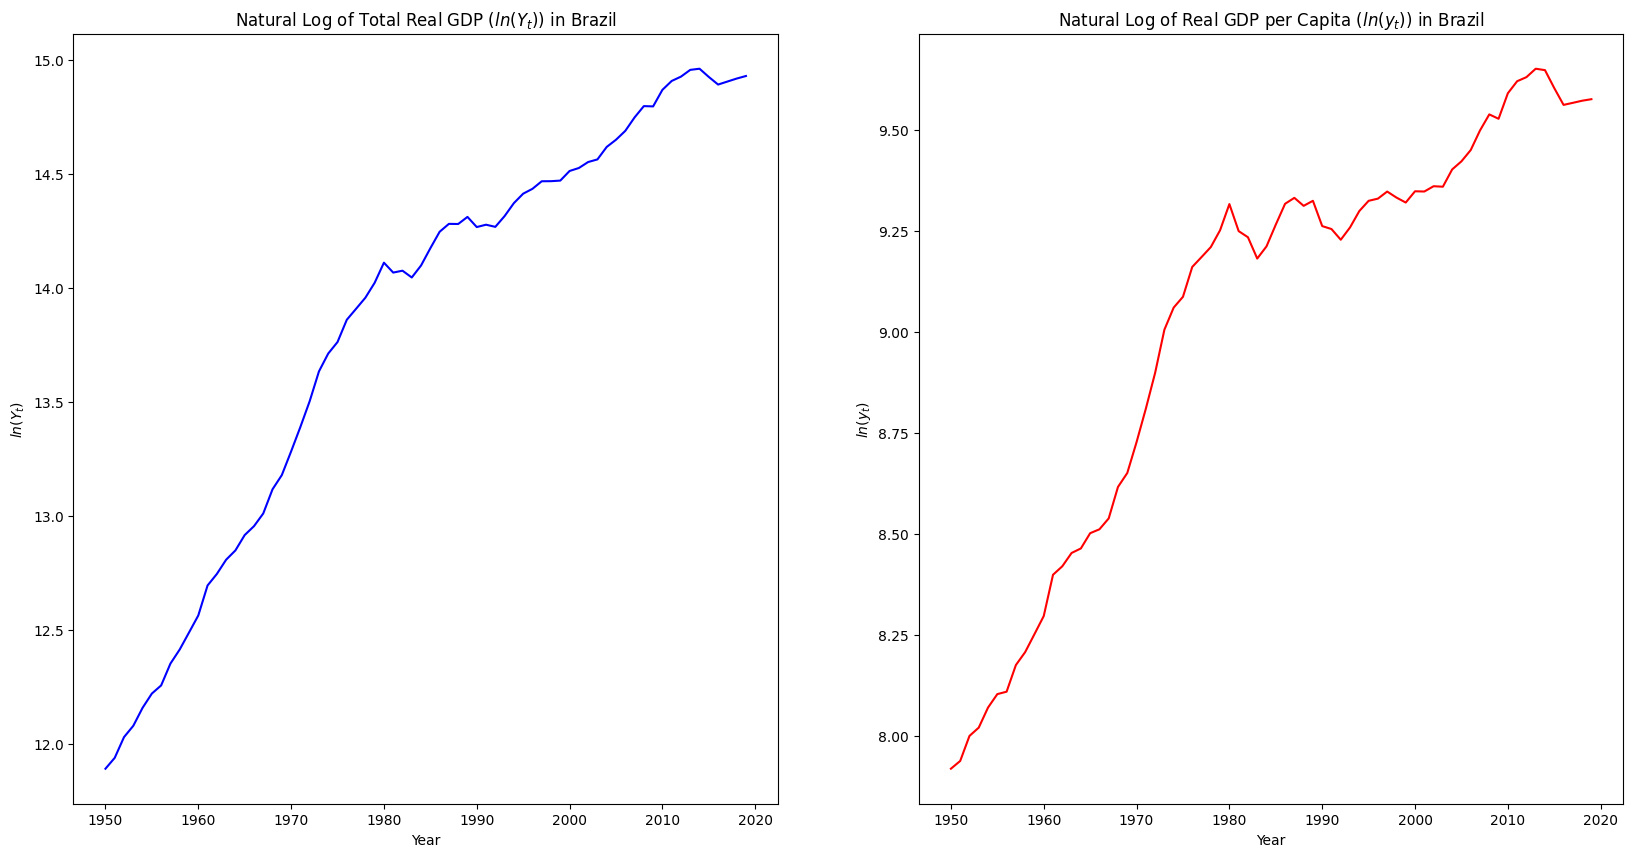

In [633]:
# plot two panels: one for log(total real GDP) and one for log(real GDP per capita)
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# plot total real GDP
ax[0].plot(df["year"], df["log_rgdpna"], color='blue')
ax[0].set_title(r'Natural Log of Total Real GDP ($ln(Y_t)$) in Brazil')
ax[0].set_xlabel("Year")
ax[0].set_ylabel("$ln(Y_t)$")

# plot real GDP per capita
ax[1].plot(df["year"], df["log_rgdpna_pc"], color='red')
ax[1].set_title(r'Natural Log of Real GDP per Capita ($ln(y_t)$) in Brazil')
ax[1].set_xlabel("Year")
ax[1].set_ylabel("$ln(y_t)$")

# save the plot
plt.savefig(os.path.join('plots', 'log_real_gdp_and_log_real_gdp_per_capita.png'), dpi=300, bbox_inches='tight')

plt.show()



Clearly, log(real GDP) seems to follow a linear trend. As our goal is to calculate trend time paths for the natural logs of real GDP and real GDP per capita, this clues us in on the type of model we should use. We can expect that an exponential model (such that log(real GDP) is linear in time) will be appropriate for our data.  

Before performing the trend calculations, let us further process the data by defining certain variables that will be used in the analysis:

In [634]:
# Define the time range for subsetting the data
ymax = 2006  # Upper limit for the sample period
ymin = 1950  # Lower limit for the sample period

# Extract the total real GDP ('rgdpna') for the specified years [1950, 2006]
Y = df.loc[(df['year'] >= ymin) & (df['year'] <= ymax), 'rgdpna']

# Extract real GDP per capita ('rgdpna_pc') for the same period
Y_pc = df.loc[(df['year'] >= ymin) & (df['year'] <= ymax), 'rgdpna_pc']

# Compute the log of total real GDP and real GDP per capita for the subsample
y = np.log(Y)  
y_pc = np.log(Y_pc)

# Create a new dataframe containing only observations from year 'ymin' onwards
df1 = df[df['year'] >= ymin]  

# Compute the sample size for the subsample (years within the specified range)
T = len(Y)  

# Compute the sample size for the full dataset starting from 'ymin'
# The formula ensures we count the total years from 'ymin' to the max year available
T_all = df1['year'].max() - (ymin - 1)

# 2. Trend calculations   
As mentioned above, we can expect that an exponential model will fit our data better than a linear model just by inspecting the plot of log(real GDP) against time. However, we will still test the following 4 models for completeness:
1. Additive linear model
2. Quadratic linear model
3. Exponential linear model
4. Exponential quadratic model

### 2.1.1 Additive linear model 
The additive linear model is given by:
$$ Y_t = \beta_0 + \beta_1 t + \epsilon_t $$ 
where $Y_t$ is the real GDP (or real GDP per capita) at time $t$, $\beta_0$ is the intercept, $\beta_1$ is the slope, $t$ is time, and $\epsilon_t$ is the error term.

Now we obtain our regression coefficients using the additive linear model. The first regressor ```x1``` is a $T \times 1$ vector of ones, and the second regressor ```x2``` is the vector $1, 2, ... , T$.

In [635]:
# Initialize an empty array of size T for a vector of ones (intercept term)
x1 = np.empty(T)  

# Initialize an empty array of size T for the time trend variable
x2 = np.empty(T)  

# Populate the vectors for regression
for t in range(T):
    x1[t] = 1  # Assign 1 to each entry in x1 to represent the intercept
    x2[t] = t + 1  # Create a time trend variable starting at 1 (since Python starts indexing at 0)

# The regression model follows the form: GDP = a + b * t
# where 'a' is the intercept and 'b' is the coefficient on the time trend.
# We use 'a' and 'b' instead of 'beta_0' and 'beta_1' for simplicity.

# Estimate coefficients (a, b) for the regression using total real GDP (Y)
a_add_lin, b_add_lin = get_regression_coefs(Y, x1, x2)

# Estimate coefficients (a, b) for the regression using real GDP per capita (Y_pc)
a_add_lin_pc, b_add_lin_pc = get_regression_coefs(Y_pc, x1, x2)

Having computed the coefficients, we can now evaluate the time trend.

In [636]:
# Initialize an empty array to store predicted total real GDP (Yhat) based on the linear model
Yhat_add_lin = np.empty(T_all)

# Initialize an empty array to store predicted real GDP per capita (Ypc_hat) based on the linear model
Ypc_hat_add_lin = np.empty(T_all)

# Compute predicted values using the estimated regression coefficients
for t in range(T_all):
    # Using the linear model: Yhat = a + b * t, where t starts at 1 (adjusted from 0-based indexing)
    Yhat_add_lin[t] = a_add_lin + b_add_lin * (t + 1)  # Predicted total real GDP
    Ypc_hat_add_lin[t] = a_add_lin_pc + b_add_lin_pc * (t + 1)  # Predicted real GDP per capita

# Apply log transformation to predicted values 
yhat_add_lin = np.log(Yhat_add_lin)  # Log of predicted total real GDP
yhat_add_lin_pc = np.log(Ypc_hat_add_lin)  # Log of predicted real GDP per capita

/var/folders/m1/v5zskq_n3473s_qmdwjwwd7w0000gn/T/ipykernel_7926/1264924659.py:14: RuntimeWarning: invalid value encountered in log
  yhat_add_lin = np.log(Yhat_add_lin)  # Log of predicted total real GDP


### 2.1.2 Additive quadratic model 
The additive quadratic model is given by:
$$ Y_t = \beta_0 + \beta_1 t + \beta_2 t^2 + \epsilon_t $$ 
With ```x1``` and ```x2``` as before, we now have a third regressor ```x3``` which is the vector $1, 2^2, ... , T^2$.   

Other than the addition of the quadratic term, the steps are the same as for the additive linear model.

In [637]:
x1 = np.empty(T)  
x2 = np.empty(T)  
x3 = np.empty(T)  # Create an empty array for the quadratic time trend variable 

# Populate the vectors for regression
for t in range(T):
    x1[t] = 1  # Assign 1 to each entry in x1 to represent the intercept
    x2[t] = t + 1  # Create a linear time trend variable starting at 1 (since Python starts indexing at 0)
    x3[t] = (t + 1) ** 2  # Create a quadratic time trend variable starting at 1 (since Python starts indexing at 0)

# Estimate coefficients (a, b, c) for the regression using total real GDP (Y)
a_add_quad, b_add_quad, c_add_quad = get_regression_coefs(Y, x1, x2, x3)
a_add_quad_pc, b_add_quad_pc, c_add_quad_pc = get_regression_coefs(Y_pc, x1, x2, x3)

# Initialize an empty array to store predicted total real GDP (Yhat) based on the quadratic model
Yhat_add_quad = np.empty(T_all)
Ypc_hat_add_quad = np.empty(T_all)

# Compute predicted values using the estimated regression coefficients
# Model: Yhat = a + b * t + c * t^2 
for t in range(T_all):
    Yhat_add_quad[t] = a_add_quad + b_add_quad * (t + 1) + c_add_quad * (t + 1) ** 2
    Ypc_hat_add_quad[t] = a_add_quad_pc + b_add_quad_pc * (t + 1) + c_add_quad_pc * (t + 1) ** 2

# Apply log transformation to predicted log GDP values
yhat_add_quad = np.log(Yhat_add_quad)
yhat_add_quad_pc = np.log(Ypc_hat_add_quad)    

### 2.1.3 Exponential linear model
The exponential linear model is given by:
$$ Y_t = e^{\beta_0 + \beta_1 t + \epsilon_t} $$ 
where $Y_t$ is the real GDP (or real GDP per capita) at time $t$.  

Taking the natural logarithm of both sides, we get:
$$ \log(Y_t) = \beta_0 + \beta_1 t + \epsilon_t $$
or, if we define $y_t = \log(Y_t)$, we have:
$$ y_t = \beta_0 + \beta_1 t + \epsilon_t $$

In [638]:
# Estimate the regression coefficients for total and per capita GDP
# Note that we are using the natural log of the dependent variable instead of the level values as we are estimating a log-linear model
# x1_bef and x2_bef are the same as before
a_exp_lin, b_exp_lin = get_regression_coefs(y, x1, x2)
a_exp_lin_pc, b_exp_lin_pc = get_regression_coefs(y_pc, x1, x2)

# Initialize an empty array to store predicted total real GDP (Yhat) based on the exponential-linear model
yhat_exp_lin = np.empty(T_all)
yhat_exp_lin_pc = np.empty(T_all)

# Compute predicted values using the estimated regression coefficients
# Model: yhat = a + b * t
for t in range(T_all):
    yhat_exp_lin[t] = a_exp_lin + b_exp_lin * (t + 1)
    yhat_exp_lin_pc[t] = a_exp_lin_pc + b_exp_lin_pc * (t + 1)

Note: Since our dependent variable is already in natural logarithm form, we do not need to take the natural logarithm of the dependent variable in this case as we did for the linear models. 

### 2.1.4 Exponential quadratic model
The exponential quadratic model is given by:
$$ Y_t = e^{\beta_0 + \beta_1 t + \beta_2 t^2 + \epsilon_t} $$  

Taking the natural logarithm of both sides, we get:
$$ \log(Y_t) = \beta_0 + \beta_1 t + \beta_2 t^2 + \epsilon_t $$  
or, if we define $y_t = \log(Y_t)$, we have:
$$ y_t = \beta_0 + \beta_1 t + \beta_2 t^2 + \epsilon_t $$  
  
Other than the addition of the quadratic term, the steps are the same as for the exponential linear model.

In [639]:
# Estimate the regression coefficients for total and per capita GDP
a_exp_quad, b_exp_quad, c_exp_quad = get_regression_coefs(y, x1, x2, x3)
a_exp_quad_pc, b_exp_quad_pc, c_exp_quad_pc = get_regression_coefs(y_pc, x1, x2, x3)

# Initialize an empty array to store predicted total real GDP (Yhat) based on the exponential-quadratic model
yhat_exp_quad = np.empty(T_all)
yhat_exp_quad_pc = np.empty(T_all)

# Compute predicted values using the estimated regression coefficients
# Model: yhat = a + b * t + c * t^2
for t in range(T_all):
    yhat_exp_quad[t] = a_exp_quad + b_exp_quad * (t + 1) + c_exp_quad * (t + 1) ** 2
    yhat_exp_quad_pc[t] = a_exp_quad_pc + b_exp_quad_pc * (t + 1) + c_exp_quad_pc * (t + 1) ** 2

### 2.1.5 Plotting the graphs as two panels
**i. Trend time paths for natural logs of real GDP**

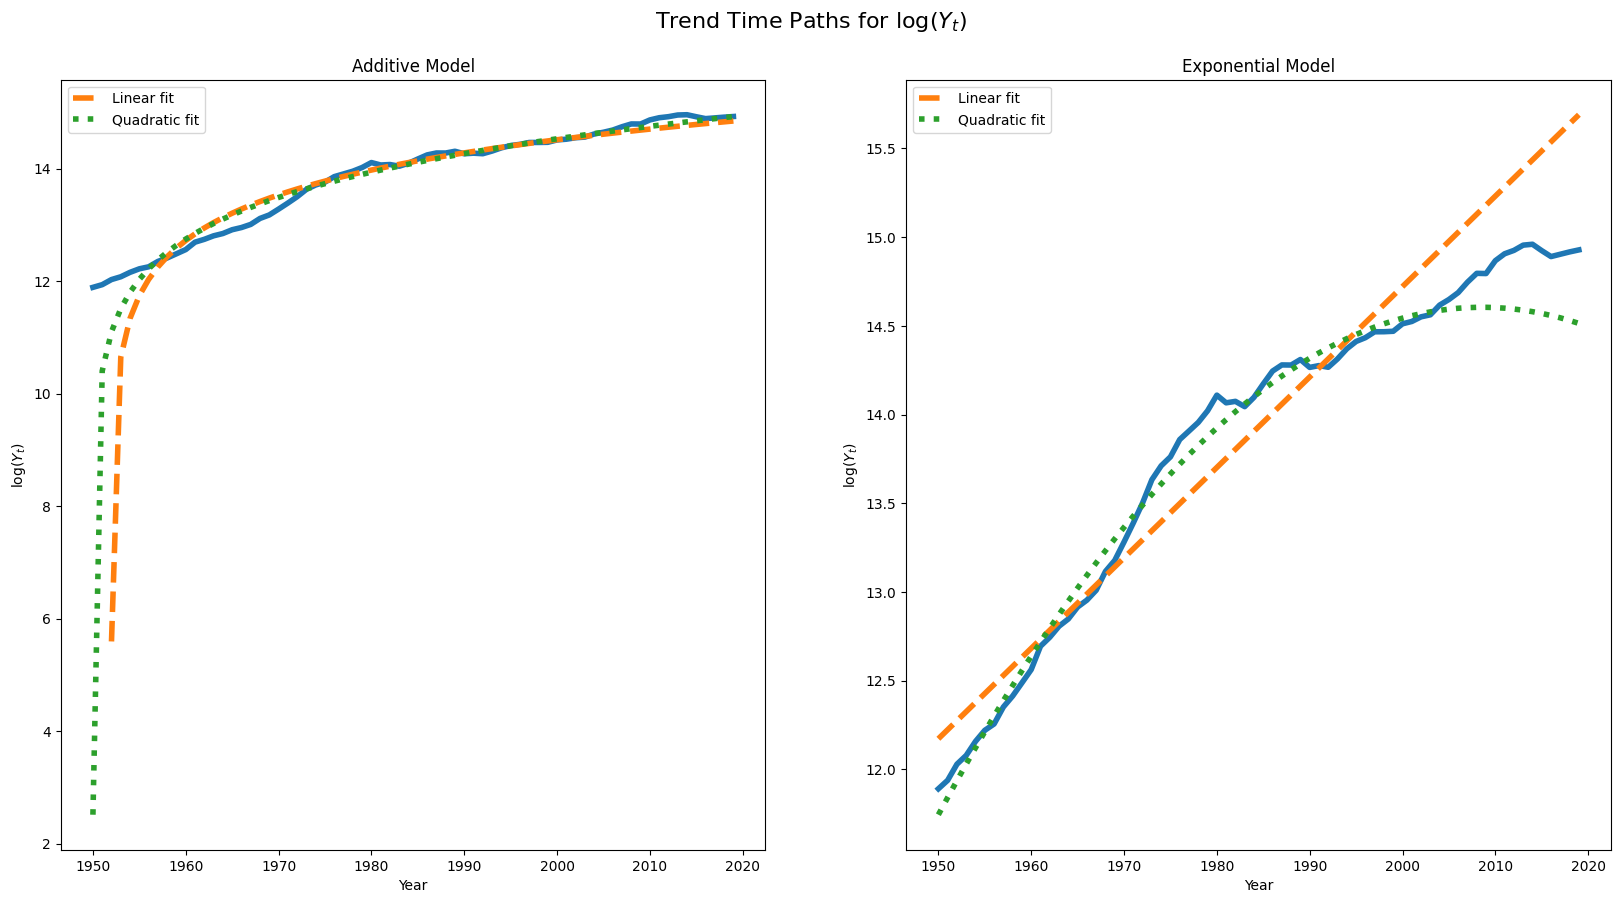

In [640]:
lw = 4

# Plot the two additive models on the left
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.plot(df1['year'], df1['log_rgdpna'], linewidth=lw)
ax1.plot(df1['year'], yhat_add_lin, linewidth=lw, linestyle = 'dashed', label = 'Linear fit')
ax1.plot(df1['year'], yhat_add_quad, linewidth=lw, linestyle = 'dotted', label = 'Quadratic fit')
ax1.set_ylabel(r'$\log(Y_t)$')
ax1.set_xlabel('Year')
ax1.set_title('Additive Model')
ax1.legend()

# Plot the two exponential models on the right
ax2.plot(df1['year'], df1['log_rgdpna'], linewidth=lw)
ax2.plot(df1['year'], yhat_exp_lin, linewidth=lw, linestyle = 'dashed', label = 'Linear fit')
ax2.plot(df1['year'], yhat_exp_quad, linewidth=lw, linestyle = 'dotted', label = 'Quadratic fit')
ax2.set_ylabel(r'$\log(Y_t)$')
ax2.set_xlabel('Year')
ax2.set_title('Exponential Model')
ax2.legend()

# Overall title for the figure
fig.suptitle(r'Trend Time Paths for $\log(Y_t)$', fontsize=16, y=0.95)

# Save the plot
plt.savefig(os.path.join('plots', 'additive_vs_exponential_logY.png'), dpi=300, bbox_inches='tight')

plt.show()

**ii. Trend time paths for real GDP**

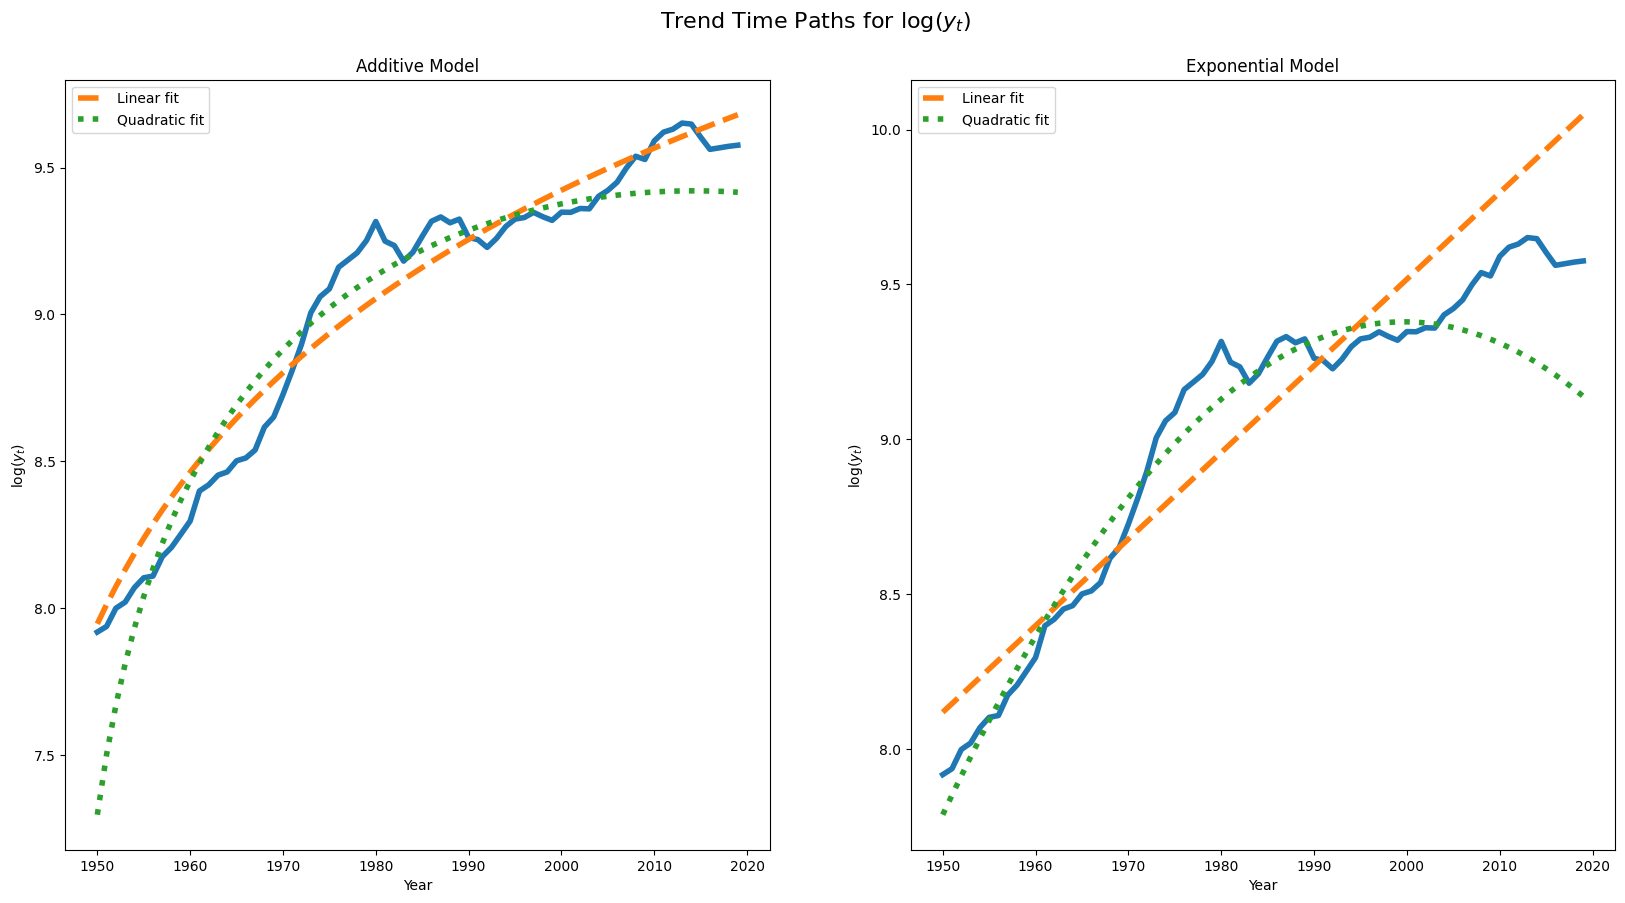

In [641]:
lw = 4

# Plot the two additive models on the left
fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(20, 10))
ax3.plot(df1['year'], df1['log_rgdpna_pc'], linewidth=lw)
ax3.plot(df1['year'], yhat_add_lin_pc, linewidth=lw, linestyle = 'dashed', label = 'Linear fit')
ax3.plot(df1['year'], yhat_add_quad_pc, linewidth=lw, linestyle = 'dotted', label = 'Quadratic fit')
ax3.set_ylabel(r'$\log(y_t)$')
ax3.set_xlabel('Year')
ax3.set_title('Additive Model')
ax3.legend()

# Plot the two exponential models on the right
ax4.plot(df1['year'], df1['log_rgdpna_pc'], linewidth=lw)
ax4.plot(df1['year'], yhat_exp_lin_pc, linewidth=lw, linestyle = 'dashed', label = 'Linear fit')
ax4.plot(df1['year'], yhat_exp_quad_pc, linewidth=lw, linestyle = 'dotted', label = 'Quadratic fit')
ax4.set_ylabel(r'$\log(y_t)$')
ax4.set_xlabel('Year')
ax4.set_title('Exponential Model')
ax4.legend()

# Overall title for the figure
fig.suptitle(r'Trend Time Paths for $\log(y_t)$', fontsize=16, y=0.95)

# Save the plot
plt.savefig(os.path.join('plots', 'additive_vs_exponential_logYpc.png'), dpi=300, bbox_inches='tight')

plt.show()

## 2.2 Splitting the data into two periods for trend calculations
Visually, it seems that none of the 4 models fit the data well. This makes sense as we see a noticeable change in the slope of the trend line around 1980. For a more accurate analysis, we will fit two separate trend lines to the data: one for the period 1950-1980 and another for the period 1981-2019. As such, we will subset the real GDP and real GDP per capita series below:

In [642]:
# subset the RGDP per capita series 
df_bef1980 = df[df['year'] < 1980]
df_aft1980 = df[df['year'] >= 1980]

ymax_bef1980 = 1970 # Upper bound for the sample period before 1980
ymin_bef1980 = 1950 # Lower bound for the sample period before 1980

ymax_aft1980 = 2006 # Upper bound for the sample period after 1980
ymin_aft1980 = 1980 # Lower bound for the sample period after 1980

# Extract the total real GDP for the specified years
Y_bef1980 = df_bef1980.loc[(df_bef1980['year'] >= ymin_bef1980) & (df_bef1980['year'] <= ymax_bef1980), 'rgdpna']
Y_aft1980 = df_aft1980.loc[(df_aft1980['year'] >= ymin_aft1980) & (df_aft1980['year'] <= ymax_aft1980), 'rgdpna']

# Extract the real GDP per capita for the specified years
Y_pc_bef1980 = df_bef1980.loc[(df_bef1980['year'] >= ymin_bef1980) & (df_bef1980['year'] <= ymax_bef1980), 'rgdpna_pc']
Y_pc_aft1980 = df_aft1980.loc[(df_aft1980['year'] >= ymin_aft1980) & (df_aft1980['year'] <= ymax_aft1980), 'rgdpna_pc']

# Compute natural log of total real GDP and real GDP per capita for the specified years
y_bef1980 = np.log(Y_bef1980)
y_aft1980 = np.log(Y_aft1980)
y_pc_bef1980 = np.log(Y_pc_bef1980)
y_pc_aft1980 = np.log(Y_pc_aft1980)

# Keep only observations from year 'ymin' onwards
df_bef1980 = df_bef1980[df_bef1980['year'] >= ymin_bef1980]
df_aft1980 = df_aft1980[df_aft1980['year'] >= ymin_aft1980]

# Compute the sample size for the 2 subsamples
T_bef1980 = len(Y_bef1980)
T_aft1980 = len(Y_aft1980)

# Compute the sample size for the full subperiods starting from 'ymin'
# The formula ensures we count the total years from 'ymin' to the max year available
T_all_bef1980 = df_bef1980['year'].max() - (ymin_bef1980 - 1)
T_all_aft1980 = df_aft1980['year'].max() - (ymin_aft1980 - 1)

### 2.2.1 Additive linear model
We follow the same steps as in section 2.1.1, but this time we fit the model to the two periods separately.

In [643]:
# Initialize empty arrays for the regression variables (intercept and time trend) for the period before 1980
x1_bef = np.empty(T_bef1980)  # Vector of ones (intercept term)
x2_bef = np.empty(T_bef1980)  # Time trend variable

# Populate the regression variables for the period before 1980
for t in range(T_bef1980):
    x1_bef[t] = 1  # Assign 1 to each entry in x1 to represent the intercept
    x2_bef[t] = t + 1  # Create a time trend variable starting at 1 (since Python starts indexing at 0)

# Estimate the linear regression coefficients for total and per capita GDP before 1980
a_add_lin_bef, b_add_lin_bef = get_regression_coefs(Y_bef1980, x1_bef, x2_bef)
a_add_lin_pc_bef, b_add_lin_pc_bef = get_regression_coefs(Y_pc_bef1980, x1_bef, x2_bef)

Having computed the regression coefficients, we can now evaluate the time trend.

In [644]:
# Initialize empty arrays for storing predicted values for the period before 1980
Yhat_add_lin_bef = np.empty(T_all_bef1980)  # Predicted total GDP
Y_pc_hat_add_lin_bef = np.empty(T_all_bef1980)  # Predicted per capita GDP

# Compute predicted values for total and per capita GDP before 1980 using the estimated coefficients
# Model: Yhat = a + b*t
for t in range(T_all_bef1980):
    Yhat_add_lin_bef[t] = a_add_lin_bef + b_add_lin_bef * (t + 1)  # Predicted total GDP
    Y_pc_hat_add_lin_bef[t] = a_add_lin_pc_bef + b_add_lin_pc_bef * (t + 1)  # Predicted per capita GDP

# Apply log transformation to obtain predicted log GDP values before 1980
yhat_add_lin_bef = np.log(Yhat_add_lin_bef)  # Log of predicted total GDP
y_pc_hat_add_lin_bef = np.log(Y_pc_hat_add_lin_bef)  # Log of predicted per capita GDP

We follow the same steps for the second subperiod to obtain the trend line for the period 1981-2019.

In [645]:
# Initialize empty arrays for the regression variables (intercept and time trend) for the period after 1980
x1_aft = np.empty(T_aft1980)  # Vector of ones (intercept term)
x2_aft = np.empty(T_aft1980)  # Time trend variable

# Populate the regression variables for the period after 1980
for t in range(T_aft1980):
    x1_aft[t] = 1  # Assign 1 to each entry in x1 to represent the intercept
    x2_aft[t] = t + 1  # Create a time trend variable starting at 1 (since Python starts indexing at 0)
    
# Estimate the linear regression coefficients for total and per capita GDP after 1980
a_add_lin_aft, b_add_lin_aft = get_regression_coefs(Y_aft1980, x1_aft, x2_aft)
a_add_lin_pc_aft, b_add_lin_pc_aft = get_regression_coefs(Y_pc_aft1980, x1_aft, x2_aft)

# Initialize empty arrays for storing predicted values for the period after 1980
Yhat_add_lin_aft = np.empty(T_all_aft1980)  # Predicted total GDP
Y_pc_hat_add_lin_aft = np.empty(T_all_aft1980)  # Predicted per capita GDP

# Compute predicted values for total and per capita GDP after 1980 using the estimated coefficients
# Model: Yhat = a + b*t
for t in range(T_all_aft1980):
    Yhat_add_lin_aft[t] = a_add_lin_aft + b_add_lin_aft * (t + 1)  # Predicted total GDP
    Y_pc_hat_add_lin_aft[t] = a_add_lin_pc_aft + b_add_lin_pc_aft * (t + 1)  # Predicted per capita GDP

# Apply log transformation to obtain predicted log GDP values after 1980
yhat_add_lin_aft = np.log(Yhat_add_lin_aft)  # Log of predicted total GDP
y_pc_hat_add_lin_aft = np.log(Y_pc_hat_add_lin_aft)  # Log of predicted per capita GDP

### 2.2.2 Additive quadratic model
We follow the same steps as in section 2.1.2, but this time we fit the model to the two periods separately.

In [646]:
x1_bef = np.empty(T_bef1980)
x2_bef = np.empty(T_bef1980)
x3_bef = np.empty(T_bef1980) # Create an empty array for the quadratic time trend variable

for t in range(T_bef1980):
    x1_bef[t] = 1
    x2_bef[t] = t + 1
    x3_bef[t] = (t + 1) ** 2 # Create a quadratic time trend variable starting at 1 (since Python starts indexing at 0)

# Estimate the regression coefficients for total and per capita GDP before 1980
a_add_quad_bef, b_add_quad_bef, c_add_quad_bef = get_regression_coefs(Y_bef1980, x1_bef, x2_bef, x3_bef)
a_add_quad_pc_bef, b_add_quad_pc_bef, c_add_quad_pc_bef = get_regression_coefs(Y_pc_bef1980, x1_bef, x2_bef, x3_bef)

Yhat_add_quad_bef = np.empty(T_all_bef1980)
Y_pc_hat_add_quad_bef = np.empty(T_all_bef1980)

# Compute predicted values for total and per capita GDP before 1980 using the estimated coefficients
# Model: Yhat = a + b*t + c*t^2
for t in range(T_all_bef1980):
    Yhat_add_quad_bef[t] = a_add_quad_bef + b_add_quad_bef * (t + 1) + c_add_quad_bef * (t + 1) ** 2
    Y_pc_hat_add_quad_bef[t] = a_add_quad_pc_bef + b_add_quad_pc_bef * (t + 1) + c_add_quad_pc_bef * (t + 1) ** 2

# Apply log transformation to obtain predicted log GDP values before 1980
yhat_add_quad_bef = np.log(Yhat_add_quad_bef)
y_pc_hat_add_quad_bef = np.log(Y_pc_hat_add_quad_bef)


A similar process is followed for the second subperiod:

In [647]:
x1_aft = np.empty(T_aft1980)
x2_aft = np.empty(T_aft1980)
x3_aft = np.empty(T_aft1980) # Create an empty array for the quadratic time trend variable

for t in range(T_aft1980):
    x1_aft[t] = 1
    x2_aft[t] = t + 1
    x3_aft[t] = (t + 1) ** 2 # Create a quadratic time trend variable starting at 1 (since Python starts indexing at 0)

# Estimate the regression coefficients for total and per capita GDP after 1980
a_add_quad_aft, b_add_quad_aft, c_add_quad_aft = get_regression_coefs(Y_aft1980, x1_aft, x2_aft, x3_aft)
a_add_quad_pc_aft, b_add_quad_pc_aft, c_add_quad_pc_aft = get_regression_coefs(Y_pc_aft1980, x1_aft, x2_aft, x3_aft)

Yhat_add_quad_aft = np.empty(T_all_aft1980)
Y_pc_hat_add_quad_aft = np.empty(T_all_aft1980)

# Compute predicted values for total and per capita GDP after 1980 using the estimated coefficients
# Model: Yhat = a + b*t + c*t^2
for t in range(T_all_aft1980):
    Yhat_add_quad_aft[t] = a_add_quad_aft + b_add_quad_aft * (t + 1) + c_add_quad_aft * (t + 1) ** 2
    Y_pc_hat_add_quad_aft[t] = a_add_quad_pc_aft + b_add_quad_pc_aft * (t + 1) + c_add_quad_pc_aft * (t + 1) ** 2

# Apply log transformation to obtain predicted log GDP values after 1980
yhat_add_quad_aft = np.log(Yhat_add_quad_aft)
y_pc_hat_add_quad_aft = np.log(Y_pc_hat_add_quad_aft)

### 2.2.3 Exponential linear model
We follow the same steps as in section 2.1.3, but this time we fit the model to the two periods separately.

In [648]:
# Estimate the regression coefficients for total and per capita GDP before 1980
# Note that we are using the natural log of the dependent variable instead of the level values as we are estimating a log-linear model
# x1_bef and x2_bef are the same as before
a_exp_lin_bef, b_exp_lin_bef = get_regression_coefs(y_bef1980, x1_bef, x2_bef)
a_exp_lin_pc_bef, b_exp_lin_pc_bef = get_regression_coefs(y_pc_bef1980, x1_bef, x2_bef)

# Initialize empty arrays for storing predicted values for the period before 1980
yhat_exp_lin_bef = np.empty(T_all_bef1980)
y_pc_hat_exp_lin_bef = np.empty(T_all_bef1980)

# Compute predicted values for total and per capita GDP before 1980 using the estimated coefficients
# Model: yhat = a + b*t
for t in range(T_all_bef1980):
    yhat_exp_lin_bef[t] = a_exp_lin_bef + b_exp_lin_bef * (t + 1)
    y_pc_hat_exp_lin_bef[t] = a_exp_lin_pc_bef + b_exp_lin_pc_bef * (t + 1)

A similar process is followed for the second subperiod:

In [649]:
# Estimate the regression coefficients for total and per capita GDP after 1980
a_exp_lin_aft, b_exp_lin_aft = get_regression_coefs(y_aft1980, x1_aft, x2_aft)
a_exp_lin_pc_aft, b_exp_lin_pc_aft = get_regression_coefs(y_pc_aft1980, x1_aft, x2_aft)

# Initialize empty arrays for storing predicted values for the period after 1980
yhat_exp_lin_aft = np.empty(T_all_aft1980)
y_pc_hat_exp_lin_aft = np.empty(T_all_aft1980)

# Compute predicted values for total and per capita GDP after 1980 using the estimated coefficients
# Model: yhat = a + b*t
for t in range(T_all_aft1980):
    yhat_exp_lin_aft[t] = a_exp_lin_aft + b_exp_lin_aft * (t + 1)
    y_pc_hat_exp_lin_aft[t] = a_exp_lin_pc_aft + b_exp_lin_pc_aft * (t + 1)

### 2.2.4 Exponential quadratic model
We follow the same steps as in section 2.1.4, but this time we fit the model to the two periods separately.

In [650]:
# Estimate the regression coefficients for total and per capita GDP before 1980
a_exp_quad_bef, b_exp_quad_bef, c_exp_quad_bef = get_regression_coefs(y_bef1980, x1_bef, x2_bef, x3_bef)
a_exp_quad_pc_bef, b_exp_quad_pc_bef, c_exp_quad_pc_bef = get_regression_coefs(y_pc_bef1980, x1_bef, x2_bef, x3_bef)

# Initialize empty arrays for storing predicted values for the period before 1980
yhat_exp_quad_bef = np.empty(T_all_bef1980)
y_pc_hat_exp_quad_bef = np.empty(T_all_bef1980)

# Compute predicted values for total and per capita GDP before 1980 using the estimated coefficients
# Model: yhat = a + b*t + c*t^2
for t in range(T_all_bef1980):
    yhat_exp_quad_bef[t] = a_exp_quad_bef + b_exp_quad_bef * (t + 1) + c_exp_quad_bef * (t + 1) ** 2
    y_pc_hat_exp_quad_bef[t] = a_exp_quad_pc_bef + b_exp_quad_pc_bef * (t + 1) + c_exp_quad_pc_bef * (t + 1) ** 2

A similar process is followed for the second subperiod:

In [651]:
# Estimate the regression coefficients for total and per capita GDP after 1980
a_exp_quad_aft, b_exp_quad_aft, c_exp_quad_aft = get_regression_coefs(y_aft1980, x1_aft, x2_aft, x3_aft)
a_exp_quad_pc_aft, b_exp_quad_pc_aft, c_exp_quad_pc_aft = get_regression_coefs(y_pc_aft1980, x1_aft, x2_aft, x3_aft)

# Initialize empty arrays for storing predicted values for the period after 1980
yhat_exp_quad_aft = np.empty(T_all_aft1980)
y_pc_hat_exp_quad_aft = np.empty(T_all_aft1980)

# Compute predicted values for total and per capita GDP after 1980 using the estimated coefficients
# Model: yhat = a + b*t + c*t^2
for t in range(T_all_aft1980):
    yhat_exp_quad_aft[t] = a_exp_quad_aft + b_exp_quad_aft * (t + 1) + c_exp_quad_aft * (t + 1) ** 2
    y_pc_hat_exp_quad_aft[t] = a_exp_quad_pc_aft + b_exp_quad_pc_aft * (t + 1) + c_exp_quad_pc_aft * (t + 1) ** 2

### 2.2.5 Plot the data and the fitted models for the two periods
**i. Trend time paths for natural logs of real GDP**

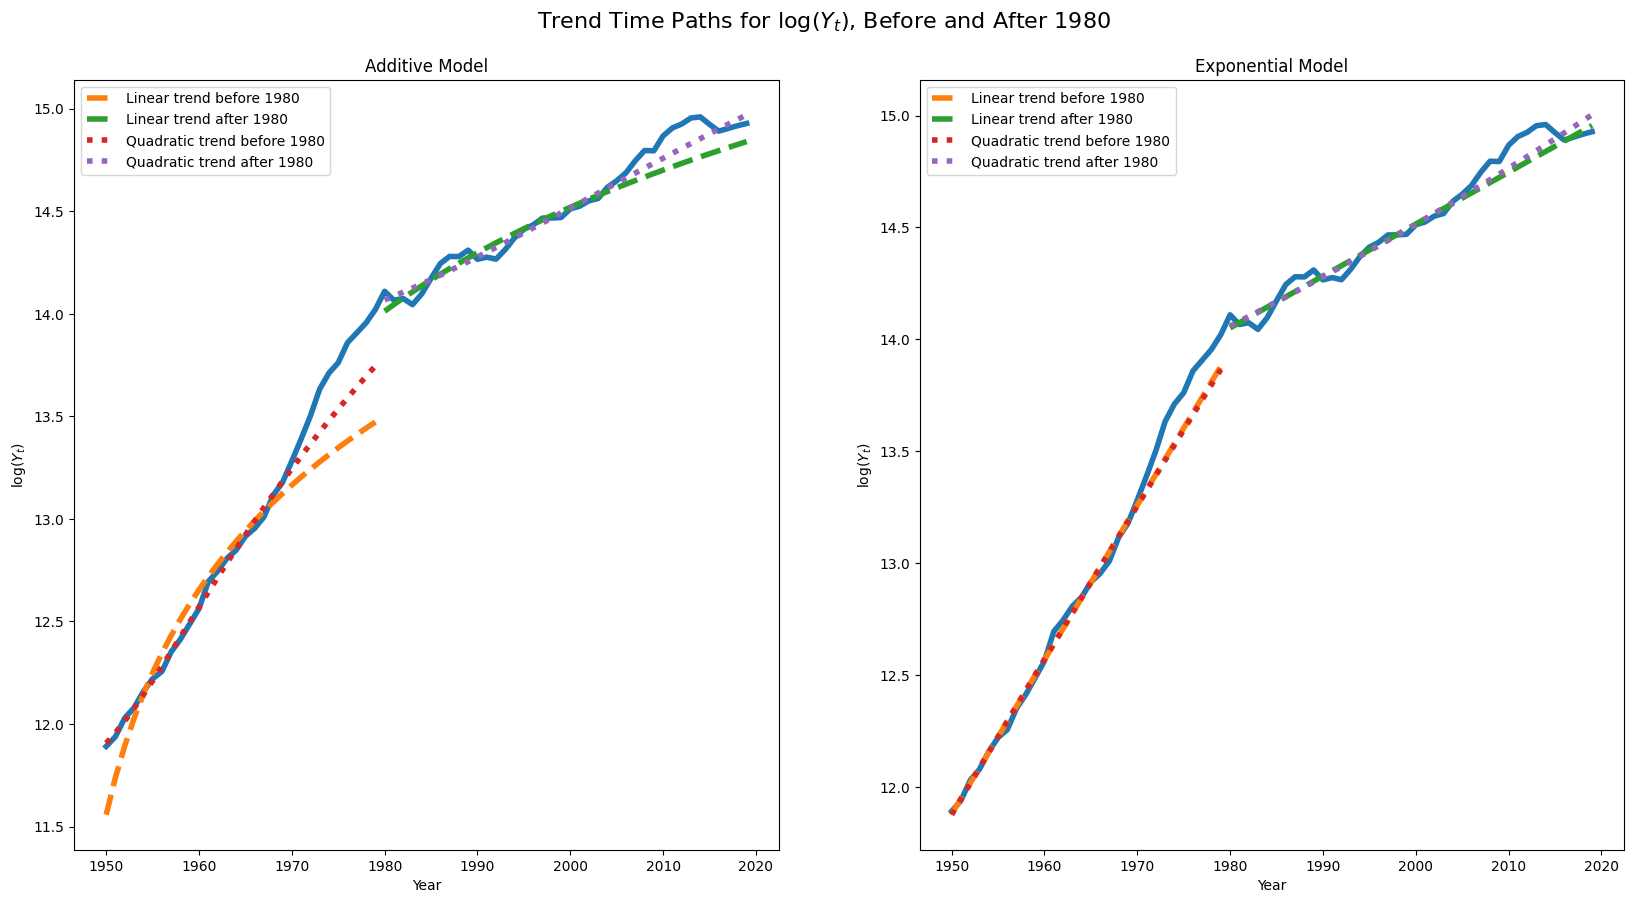

In [652]:
lw = 4

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.plot(df['year'], df['log_rgdpna'], linewidth=lw)
ax1.plot(df_bef1980['year'], yhat_add_lin_bef, linewidth=lw, linestyle = 'dashed', label='Linear trend before 1980')
ax1.plot(df_aft1980['year'], yhat_add_lin_aft, linewidth=lw, linestyle = 'dashed', label='Linear trend after 1980')
ax1.plot(df_bef1980['year'], yhat_add_quad_bef, linewidth=lw, linestyle = 'dotted', label='Quadratic trend before 1980')
ax1.plot(df_aft1980['year'], yhat_add_quad_aft, linewidth=lw, linestyle = 'dotted', label='Quadratic trend after 1980')
ax1.set_ylabel(r'$\log(Y_t)$')
ax1.set_xlabel('Year')
ax1.set_title('Additive Model')
ax1.legend()

ax2.plot(df['year'], df['log_rgdpna'], linewidth=lw)
ax2.plot(df_bef1980['year'], yhat_exp_lin_bef, linewidth=lw, linestyle = 'dashed', label='Linear trend before 1980')
ax2.plot(df_aft1980['year'], yhat_exp_lin_aft, linewidth=lw, linestyle = 'dashed', label='Linear trend after 1980')
ax2.plot(df_bef1980['year'], yhat_exp_quad_bef, linewidth=lw, linestyle = 'dotted', label='Quadratic trend before 1980')
ax2.plot(df_aft1980['year'], yhat_exp_quad_aft, linewidth=lw, linestyle = 'dotted', label='Quadratic trend after 1980')
ax2.set_ylabel(r'$\log(Y_t)$')
ax2.set_xlabel('Year')
ax2.set_title('Exponential Model')
ax2.legend()

# Overall title for the figure
fig.suptitle(r'Trend Time Paths for $\log(Y_t)$, Before and After 1980', fontsize=16, y=0.95)

# Save the plot
plt.savefig(os.path.join('plots', 'additive_vs_exponential_logY_before_after.png'), dpi=300, bbox_inches='tight')

plt.show()

**ii. Trend time paths for natural logs of real GDP per capita**

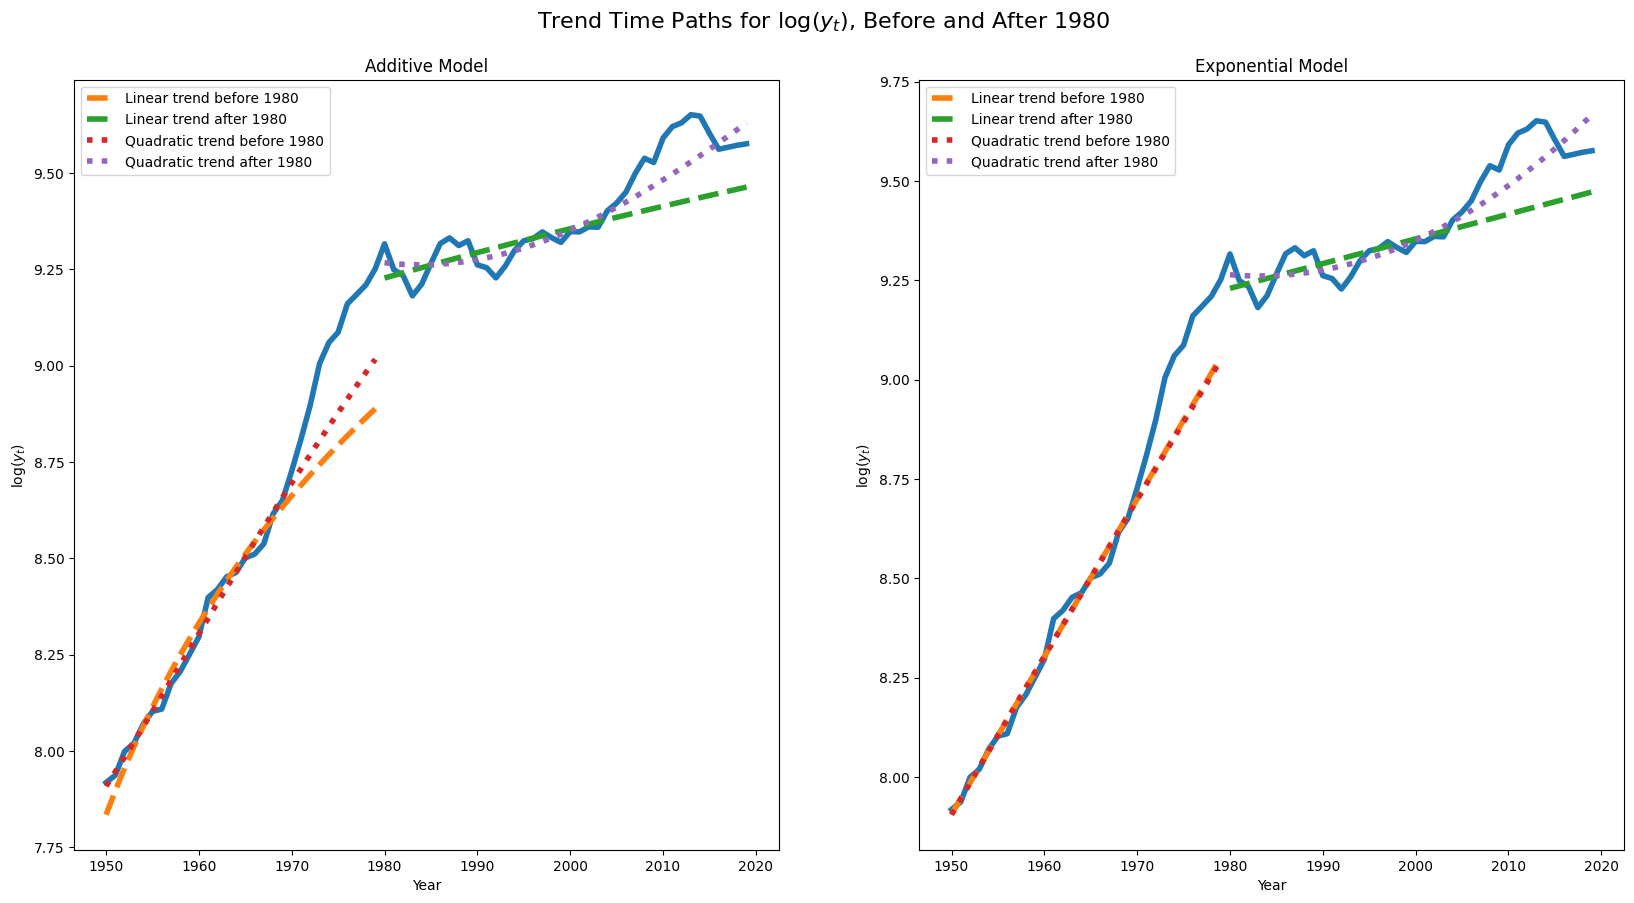

In [653]:
lw = 4

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.plot(df['year'], df['log_rgdpna_pc'], linewidth=lw)
ax1.plot(df_bef1980['year'], y_pc_hat_add_lin_bef, linewidth=lw, linestyle = 'dashed', label='Linear trend before 1980')
ax1.plot(df_aft1980['year'], y_pc_hat_add_lin_aft, linewidth=lw, linestyle = 'dashed', label='Linear trend after 1980')
ax1.plot(df_bef1980['year'], y_pc_hat_add_quad_bef, linewidth=lw, linestyle = 'dotted', label='Quadratic trend before 1980')
ax1.plot(df_aft1980['year'], y_pc_hat_add_quad_aft, linewidth=lw, linestyle = 'dotted', label='Quadratic trend after 1980')
ax1.set_ylabel(r'$\log(y_t)$')
ax1.set_xlabel('Year')
ax1.set_title('Additive Model')
ax1.legend()

ax2.plot(df['year'], df['log_rgdpna_pc'], linewidth=lw)
ax2.plot(df_bef1980['year'], y_pc_hat_exp_lin_bef, linewidth=lw, linestyle = 'dashed', label='Linear trend before 1980')
ax2.plot(df_aft1980['year'], y_pc_hat_exp_lin_aft, linewidth=lw, linestyle = 'dashed', label='Linear trend after 1980')
ax2.plot(df_bef1980['year'], y_pc_hat_exp_quad_bef, linewidth=lw, linestyle = 'dotted', label='Quadratic trend before 1980')
ax2.plot(df_aft1980['year'], y_pc_hat_exp_quad_aft, linewidth=lw, linestyle = 'dotted', label='Quadratic trend after 1980')
ax2.set_ylabel(r'$\log(y_t)$')
ax2.set_xlabel('Year')
ax2.set_title('Exponential Model')
ax2.legend()

# Overall title for the figure
fig.suptitle(r'Trend Time Paths for $\log(y_t)$, Before and After 1980', fontsize=16, y=0.95)

# Save the plot
plt.savefig(os.path.join('plots', 'additive_vs_exponential_logYpc_before_after.png'), dpi=300, bbox_inches='tight')

plt.show()

## 2.3 Robustness Checks  
As a robustness exercise, we will plot the level of real GDP and real GDP per capita against time, along with the fitted trend lines. 

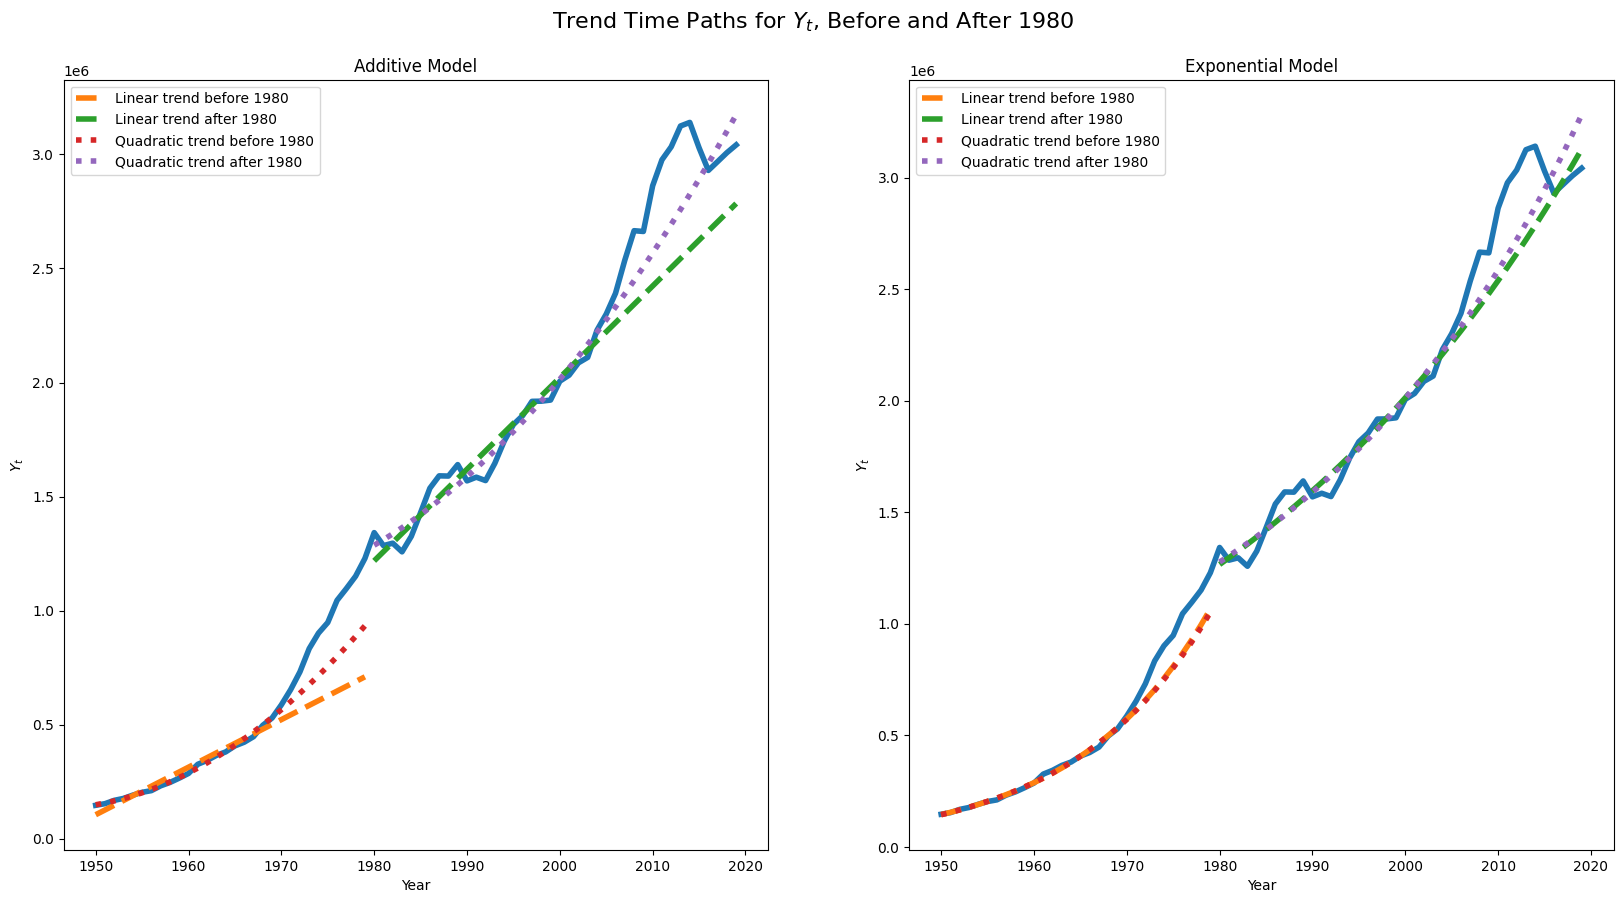

In [654]:
lw = 4

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.plot(df['year'], df['rgdpna'], linewidth=lw)
ax1.plot(df_bef1980['year'], Yhat_add_lin_bef, linewidth=lw, linestyle = 'dashed', label='Linear trend before 1980')
ax1.plot(df_aft1980['year'], Yhat_add_lin_aft, linewidth=lw, linestyle = 'dashed', label='Linear trend after 1980')
ax1.plot(df_bef1980['year'], Yhat_add_quad_bef, linewidth=lw, linestyle = 'dotted', label='Quadratic trend before 1980')
ax1.plot(df_aft1980['year'], Yhat_add_quad_aft, linewidth=lw, linestyle = 'dotted', label='Quadratic trend after 1980')
ax1.set_ylabel(r'$Y_t$')
ax1.set_xlabel('Year')
ax1.set_title('Additive Model')
ax1.legend()

ax2.plot(df['year'], df['rgdpna'], linewidth=lw)
ax2.plot(df_bef1980['year'], np.exp(yhat_exp_lin_bef), linewidth=lw, linestyle = 'dashed', label='Linear trend before 1980')
ax2.plot(df_aft1980['year'], np.exp(yhat_exp_lin_aft), linewidth=lw, linestyle = 'dashed', label='Linear trend after 1980')
ax2.plot(df_bef1980['year'], np.exp(yhat_exp_quad_bef), linewidth=lw, linestyle = 'dotted', label='Quadratic trend before 1980')
ax2.plot(df_aft1980['year'], np.exp(yhat_exp_quad_aft), linewidth=lw, linestyle = 'dotted', label='Quadratic trend after 1980')
ax2.set_ylabel(r'$Y_t$')
ax2.set_xlabel('Year')
ax2.set_title('Exponential Model')
ax2.legend()

# Overall title for the figure
fig.suptitle(r'Trend Time Paths for $Y_t$, Before and After 1980', fontsize=16, y=0.95)

# Save the plot
plt.savefig(os.path.join('plots', 'additive_vs_exponential_Y_before_after.png'), dpi=300, bbox_inches='tight')

plt.show()

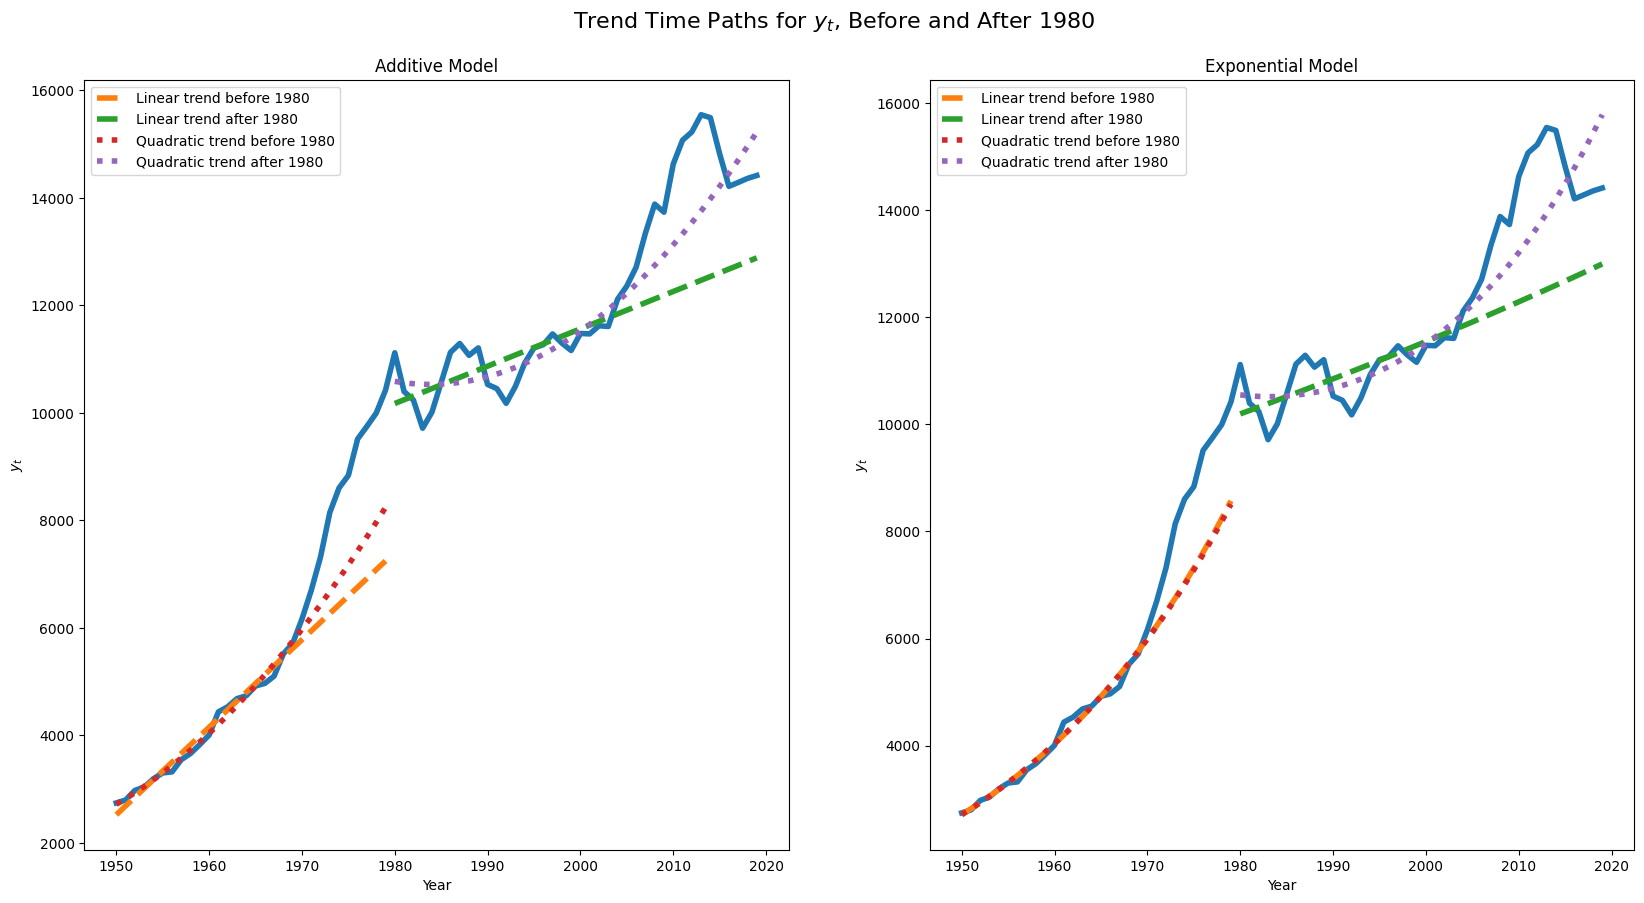

In [655]:
lw = 4

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.plot(df['year'], df['rgdpna_pc'], linewidth=lw)
ax1.plot(df_bef1980['year'], Y_pc_hat_add_lin_bef, linewidth=lw, linestyle = 'dashed', label='Linear trend before 1980')
ax1.plot(df_aft1980['year'], Y_pc_hat_add_lin_aft, linewidth=lw, linestyle = 'dashed', label='Linear trend after 1980')
ax1.plot(df_bef1980['year'], Y_pc_hat_add_quad_bef, linewidth=lw, linestyle = 'dotted', label='Quadratic trend before 1980')
ax1.plot(df_aft1980['year'], Y_pc_hat_add_quad_aft, linewidth=lw, linestyle = 'dotted', label='Quadratic trend after 1980')
ax1.set_ylabel(r'$y_t$')
ax1.set_xlabel('Year')
ax1.set_title('Additive Model')
ax1.legend()

ax2.plot(df['year'], df['rgdpna_pc'], linewidth=lw)
ax2.plot(df_bef1980['year'], np.exp(y_pc_hat_exp_lin_bef), linewidth=lw, linestyle = 'dashed', label='Linear trend before 1980')
ax2.plot(df_aft1980['year'], np.exp(y_pc_hat_exp_lin_aft), linewidth=lw, linestyle = 'dashed', label='Linear trend after 1980')
ax2.plot(df_bef1980['year'], np.exp(y_pc_hat_exp_quad_bef), linewidth=lw, linestyle = 'dotted', label='Quadratic trend before 1980')
ax2.plot(df_aft1980['year'], np.exp(y_pc_hat_exp_quad_aft), linewidth=lw, linestyle = 'dotted', label='Quadratic trend after 1980')
ax2.set_ylabel(r'$y_t$')
ax2.set_xlabel('Year')
ax2.set_title('Exponential Model')
ax2.legend()

# Overall title for the figure
fig.suptitle(r'Trend Time Paths for $y_t$, Before and After 1980', fontsize=16, y=0.95)

# Save the plot
plt.savefig(os.path.join('plots', 'additive_vs_exponential_Ypc_before_after.png'), dpi=300, bbox_inches='tight')

plt.show()


# 3. Extract TFP measure  
Labour augmenting production function:
$$ Y = K^\alpha(AL)^{1-\alpha} $$  
where $Y$ is real GDP, $K$ is the capital stock, $A$ is Total Factor Productivity (TFP) and $L$ is labour, measured as the number of employed workers.  

Since A is a residual and encompasses all factors that affect GDP but are not accounted for by capital and labour, we can extract TFP by rearranging the production function as follows:  
$$ A = \left( \frac{Y}{K^\alpha L^{1-\alpha}} \right)^{\frac{1}{1-\alpha}} $$

In [656]:
alpha = 0.3

# Isolate the columns of interest
df3 = df[['year','rgdpna', 'emp', 'rnna', 'hc']].copy()

# Calculate TFP using the labour-augmenting production function
df3['TFP'] = (df3['rgdpna'] / ((df3['rnna']**alpha) * (df3['emp']**(1-alpha))))**(1/(1-alpha))

In [657]:
df3

,year,rgdpna,emp,rnna,hc,TFP
0,1950,1.458805e+05,16.988243,6.085668e+05,1.300444,4655.871612
1,1951,1.530244e+05,17.461807,6.542803e+05,1.308093,4701.553710
2,1952,1.675756e+05,17.952208,7.058516e+05,1.315788,5040.212775
3,1953,1.760916e+05,18.460180,7.379514e+05,1.323528,5161.874512
4,1954,1.905373e+05,18.986502,7.806124e+05,1.331313,5483.454379
...,...,...,...,...,...,...
65,2015,3.029302e+06,92.447227,1.328308e+07,2.813660,17390.998692
66,2016,2.930064e+06,90.626472,1.338209e+07,2.880657,16862.281458
67,2017,2.968826e+06,90.501389,1.346787e+07,2.949250,17158.544275
68,2018,3.007932e+06,92.090942,1.358428e+07,3.019475,17117.321442


# 4. Growth accounting

For our growth accounting, we will consider the following subperiods: 1950-1980, 1981-1994 and 1995-2019. The justification for these subperiods can be found in the report.  
We will calculate the contributions of capital accumulation, labour input, and TFP to growth in real GDP for each of these subperiods. 

In [658]:
# Define the subperiods for growth rate analysis
subperiods = [(1950, 1980), (1981, 1994), (1995, 2019)]

# Set the capital share parameter (α) in the production function
alpha = 0.3  

# Initialize an empty DataFrame to store average growth rates and factor contributions
avg_growth_rates = pd.DataFrame(columns=[
    'Y growth', 'K growth', 'L growth', 'TFP growth', 
    'K contribution', 'L contribution', 'TFP contribution', 'Summation check'
])

# Loop through the defined subperiods and compute growth rates
for start_year, end_year in subperiods:
    # Filter the dataset for the current subperiod
    sub_df = df3[(df3['year'] >= start_year) & (df3['year'] <= end_year)].copy()

    # Compute average growth rates using log differences
    # Growth rate formula: log(X_t) - log(X_0) approximates % growth over time
    growth_rates = {
        'Y growth': np.log(sub_df['rgdpna'].iloc[-1]) - np.log(sub_df['rgdpna'].iloc[0]),  # Output growth
        'K growth': np.log(sub_df['rnna'].iloc[-1]) - np.log(sub_df['rnna'].iloc[0]),  # Capital growth
        'L growth': np.log(sub_df['emp'].iloc[-1]) - np.log(sub_df['emp'].iloc[0]),  # Labor growth
        'TFP growth': np.log(sub_df['TFP'].iloc[-1]) - np.log(sub_df['TFP'].iloc[0])  # TFP growth
    }

    # Store the computed growth rates in the DataFrame
    avg_growth_rates.loc[f'{start_year}-{end_year}'] = growth_rates

    # Compute the contributions of capital (K), labor (L), and TFP to output growth
    Y_growth = growth_rates['Y growth']
    K_growth = growth_rates['K growth']
    L_growth = growth_rates['L growth']
    TFP_growth = growth_rates['TFP growth']

    # Factor contributions based on the labour augmenting production function's decomposition:
    K_contribution = alpha * (K_growth / Y_growth)
    L_contribution = (1 - alpha) * (L_growth / Y_growth)
    TFP_contribution = (1 - alpha) * (TFP_growth / Y_growth)
    Summation_check = K_contribution + L_contribution + TFP_contribution # Mathematically should sum to 1

    # Store the computed factor contributions in the DataFrame
    avg_growth_rates.loc[f'{start_year}-{end_year}', 'K contribution'] = K_contribution
    avg_growth_rates.loc[f'{start_year}-{end_year}', 'L contribution'] = L_contribution
    avg_growth_rates.loc[f'{start_year}-{end_year}', 'TFP contribution'] = TFP_contribution
    avg_growth_rates.loc[f'{start_year}-{end_year}', 'Summation check'] = Summation_check
    
# Display the DataFrame with average growth rates and contributions
avg_growth_rates


,Y growth,K growth,L growth,TFP growth,K contribution,L contribution,TFP contribution,Summation check
1950-1980,2.218958,2.078699,0.935876,1.343193,0.281037,0.295235,0.423728,1.0
1981-1994,0.304581,0.416585,0.325123,-0.068544,0.410320,0.747211,-0.157531,1.0
1995-2019,0.516045,0.531148,0.400780,0.108793,0.308780,0.543646,0.147574,1.0


To visualise the contributions of each factor to growth in real GDP, we will plot a bar chart for each subperiod.

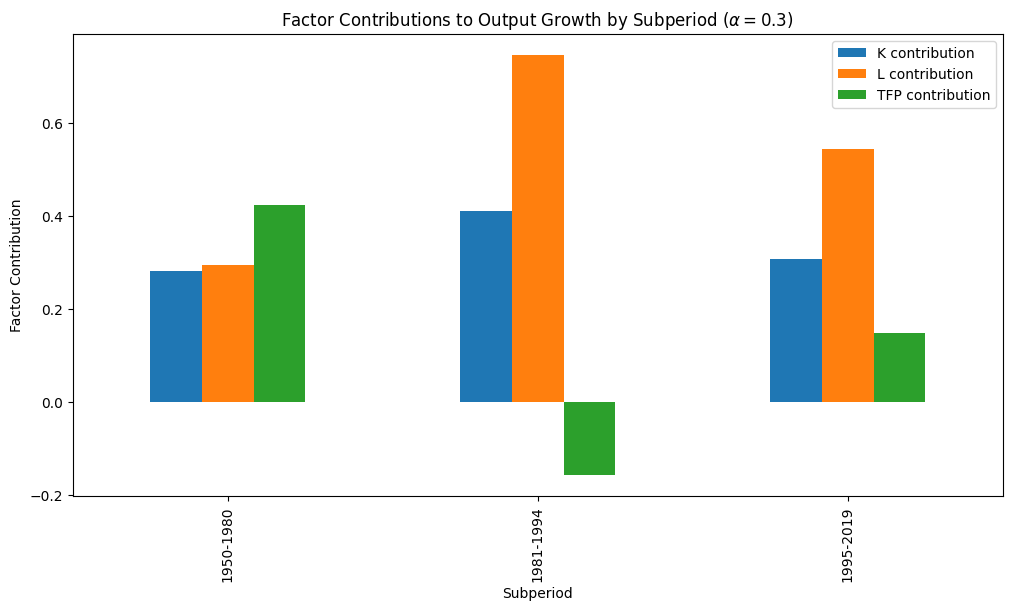

In [659]:
# plot a bar graph to compare the factor contributions in the 3 periods 
avg_growth_rates[['K contribution', 'L contribution', 'TFP contribution']].plot(kind='bar', figsize=(12, 6))
plt.ylabel('Factor Contribution')
plt.xlabel('Subperiod')
plt.title(r'Factor Contributions to Output Growth by Subperiod ($\alpha = 0.3$)')

# Save the plot
plt.savefig(os.path.join('plots', 'factor_contributions_alpha_0.3.png'), dpi=300, bbox_inches='tight')

plt.show()

### 4.1 Plot human capital against time
We hypothesise that one reason for the modest recovery in TFP growth in the 1995-2019 period is the increase in the level of human capital. To test this hypothesis, we will plot the trend in ```hc``` against time, where ```hc``` is the human capital index based on years of schooling and the returns to education.

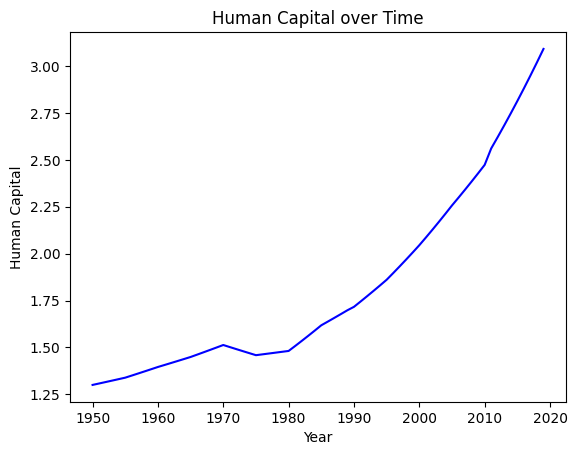

In [660]:
# plot hc over time
plt.plot(df['year'], df['hc'], color='blue')
plt.title('Human Capital over Time')
plt.xlabel('Year')
plt.ylabel('Human Capital')

# Save the plot
plt.savefig(os.path.join('plots', 'human_capital_over_time.png'), dpi=300, bbox_inches='tight')

plt.show()


### 4.2 Robustness checks by varying the value of alpha

In [661]:
# Other values of alpha to test: 0.2, 0.4
alpha_values = [0.2, 0.4]

# Initialise a dictionary to store DataFrames for different alpha values
robustness_check = {}

# Loop through each alpha value
for alpha in alpha_values:
    # Create a copy of the dataset and recalculate TFP for the new alphas
    df_alpha = df[['year', 'rgdpna', 'emp', 'rnna', 'hc']].copy()
    df_alpha['TFP'] = (df_alpha['rgdpna'] / (df_alpha['rnna']**alpha * df_alpha['emp']**(1-alpha)))**(1/(1-alpha))

    # Initialize an empty DataFrame to store growth rates and contributions
    avg_growth_rates = pd.DataFrame(columns=[
        'Y growth', 'K growth', 'L growth', 'TFP growth', 
        'K contribution', 'L contribution', 'TFP contribution', 'Summation check'
    ])

    # Loop through the defined subperiods and compute growth rates
    for start_year, end_year in subperiods:
        # Filter the dataset for the current subperiod
        sub_df = df_alpha[(df_alpha['year'] >= start_year) & (df_alpha['year'] <= end_year)].copy()

        # Compute average growth rates using log differences
        growth_rates = {
            'Y growth': np.log(sub_df['rgdpna'].iloc[-1]) - np.log(sub_df['rgdpna'].iloc[0]),  # Output growth
            'K growth': np.log(sub_df['rnna'].iloc[-1]) - np.log(sub_df['rnna'].iloc[0]),  # Capital growth
            'L growth': np.log(sub_df['emp'].iloc[-1]) - np.log(sub_df['emp'].iloc[0]),  # Labor growth
            'TFP growth': np.log(sub_df['TFP'].iloc[-1]) - np.log(sub_df['TFP'].iloc[0])  # TFP growth
        }

        # Compute factor contributions to output growth
        Y_growth = growth_rates['Y growth']
        K_growth = growth_rates['K growth']
        L_growth = growth_rates['L growth']
        TFP_growth = growth_rates['TFP growth']

        K_contribution = alpha * (K_growth / Y_growth)
        L_contribution = (1 - alpha) * (L_growth / Y_growth)
        TFP_contribution = (1 - alpha) * (TFP_growth / Y_growth)
        Summation_check = K_contribution + L_contribution + TFP_contribution  # Should sum to ~1

        # Store results in DataFrame
        avg_growth_rates.loc[f'{start_year}-{end_year}'] = {
            **growth_rates,
            'K contribution': K_contribution,
            'L contribution': L_contribution,
            'TFP contribution': TFP_contribution,
            'Summation check': Summation_check
        }
    
    # Store the DataFrame for this alpha in the results dictionary
    robustness_check[alpha] = avg_growth_rates

# Display results for each alpha
for alpha, df_alphas in robustness_check.items():
    print(f'Alpha value: {alpha}')
    display(df_alphas)

Alpha value: 0.2


,Y growth,K growth,L growth,TFP growth,K contribution,L contribution,TFP contribution,Summation check
1950-1980,2.218958,2.078699,0.935876,1.318146,0.187358,0.337411,0.475231,1.0
1981-1994,0.304581,0.416585,0.325123,-0.048543,0.273546,0.853956,-0.127502,1.0
1995-2019,0.516045,0.531148,0.400780,0.111490,0.205853,0.621310,0.172837,1.0


Alpha value: 0.4


,Y growth,K growth,L growth,TFP growth,K contribution,L contribution,TFP contribution,Summation check
1950-1980,2.218958,2.078699,0.935876,1.376588,0.374716,0.253058,0.372225,1.0
1981-1994,0.304581,0.416585,0.325123,-0.095212,0.547093,0.640467,-0.187560,1.0
1995-2019,0.516045,0.531148,0.400780,0.105197,0.411707,0.465982,0.122311,1.0


Once again for visualisation purposes, we will plot a bar chart for each subperiod, but this time we will vary the value of $\alpha$ to see how the contributions of capital accumulation, labour input, and TFP to growth in real GDP change.

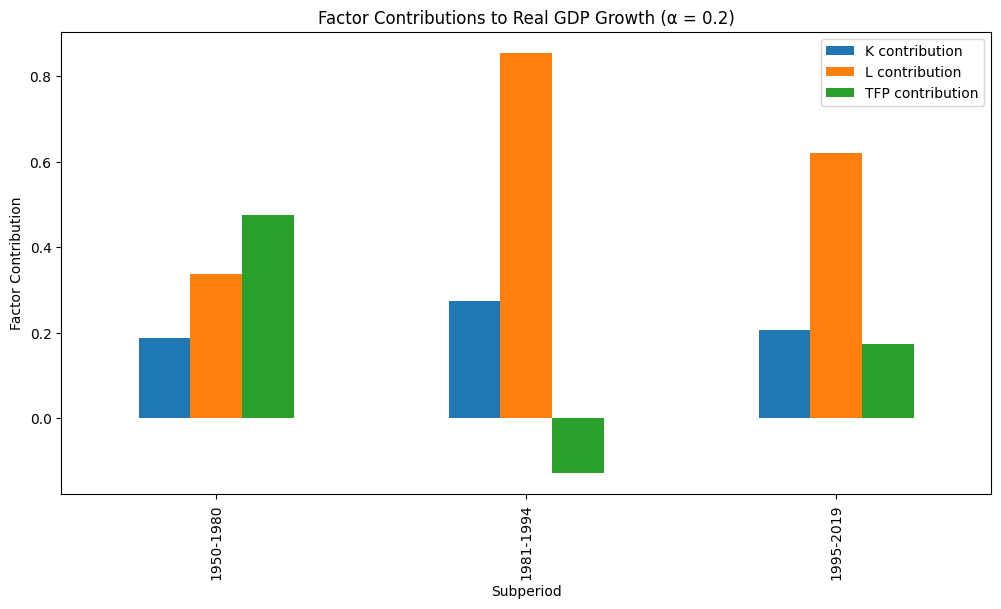

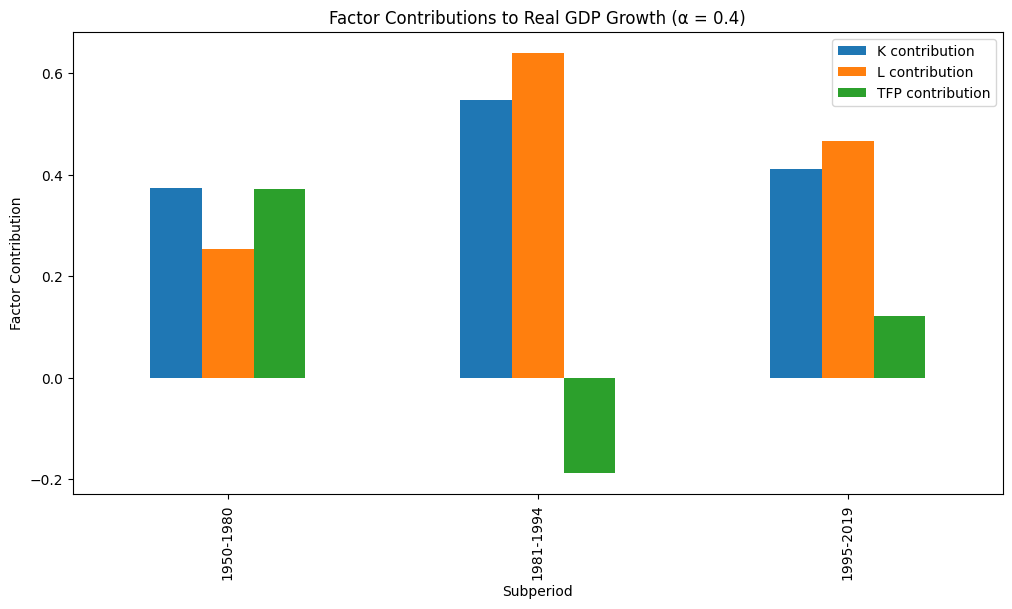

In [662]:
# Plot the factor contributions for different alpha values (in separate plots)
for alpha, df_alphas in robustness_check.items():
    df_alphas[['K contribution', 'L contribution', 'TFP contribution']].plot(kind='bar', figsize=(12, 6))
    plt.ylabel('Factor Contribution')
    plt.xlabel('Subperiod')
    plt.title(f'Factor Contributions to Real GDP Growth (α = {alpha})')
    # Save the plot
    plt.savefig(os.path.join('plots', f'factor_contributions_bar_alpha_{alpha}.png'), dpi=300, bbox_inches='tight')

    plt.show()


# 5. Labour productivity  
Now, we will construct a series for labour productivity, i.e., GDP per worker.  
This is simply: $\frac{Y}{L}$, where $Y$ is real GDP and $L$ is the number of employed workers. 

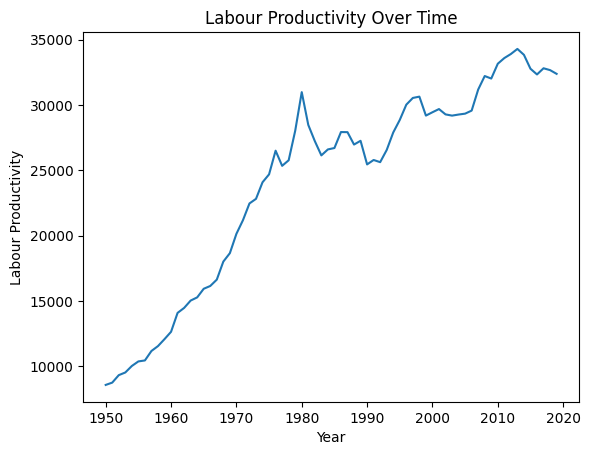

In [663]:
df3['labour_productivity'] = df3['rgdpna'] / df3['emp']

plt.plot(df3['year'], df3['labour_productivity'])
plt.ylabel('Labour Productivity')
plt.xlabel('Year')
plt.title('Labour Productivity Over Time')

# Save the plot
plt.savefig(os.path.join('plots', 'labour_productivity_over_time.png'), dpi=300, bbox_inches='tight')

plt.show()

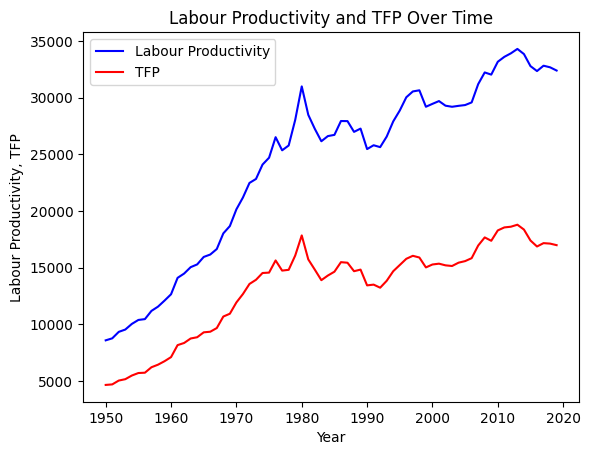

In [664]:
plt.plot(df3['year'], df3['labour_productivity'], label='Labour Productivity', color='blue')
plt.plot(df3['year'], df3['TFP'], label= 'TFP', color='red')
plt.ylabel('Labour Productivity, TFP')
plt.xlabel('Year')
plt.title('Labour Productivity and TFP Over Time')
plt.legend()

# Save the plot
plt.savefig(os.path.join('plots', 'labour_productivity_TFP.png'), dpi=300, bbox_inches='tight')

plt.show()

# 6. Solow Model  
As before, we base our Solow model analysis on the labour augmenting production function: 
$$ Y = K^\alpha(AL)^{1-\alpha} $$  
where $Y$ is real GDP, $K$ is the capital stock, $A$ is Total Factor Productivity (TFP) and $L$ is labour, measured as the number of employed workers.  

Here are the steps we will follow so that we can easily generate the plots and tables for the Solow model analysis:
- Take the natural logarithm of key variables ($K, L, A$) to facilitate growth rate analysis and visualisation
- Compute capital per worker (log-transformed)
- Compute effective labour ($AL$) 
- Compute ```k_tilde```, given by ```k_tilde``` = $\frac{K}{AL}$

In [665]:
df_solow = df3[['year', 'rgdpna', 'emp', 'rnna', 'TFP']].copy()

# Calculate the natural log of the variables
df_solow['logK'] = np.log(df_solow['rnna'])
df_solow['logL'] = np.log(df_solow['emp'])
df_solow['logA'] = np.log(df_solow['TFP'])

# Calculate log(k) given k = K/L
df_solow['logk'] = np.log(df_solow['rnna']/df['emp'])

# Calculate L*A 
df_solow['LA'] = df_solow['emp']*df_solow['TFP']

# Calculate k_tilde, given k_tilde = K/(LA)
df_solow['k_tilde'] = df_solow['rnna']/df_solow['LA']

df_solow.head()

,year,rgdpna,emp,rnna,TFP,logK,logL,logA,logk,LA,k_tilde
0,1950,145880.453125,16.988243,608566.8125,4655.871612,13.318862,2.832522,8.445884,10.486340,79095.078802,7.694117
1,1951,153024.359375,17.461807,654280.3125,4701.553710,13.391291,2.860016,8.455648,10.531275,82097.624670,7.969540
2,1952,167575.578125,17.952208,705851.5625,5040.212775,13.467160,2.887713,8.525204,10.579447,90482.945912,7.800935
3,1953,176091.625000,18.460180,737951.4375,5161.874512,13.511633,2.915616,8.549055,10.596017,95289.134081,7.744340
4,1954,190537.328125,18.986502,780612.4375,5483.454379,13.567834,2.943728,8.609491,10.624106,104111.615864,7.497842


Let us make a few plots for our Solow model analysis:

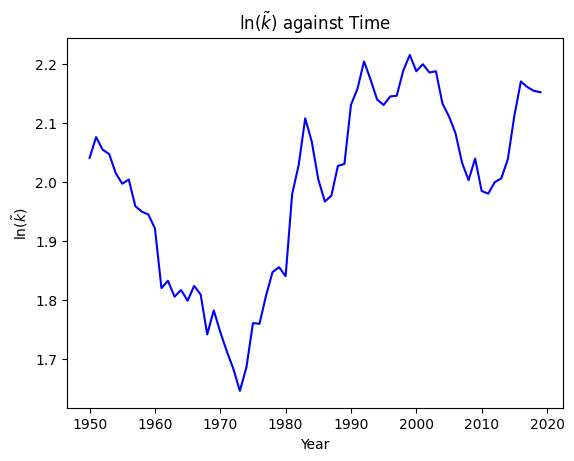

In [666]:
# Plot the natural log of k_tilda over time for the labour-augmenting production function
plt.plot(df_solow['year'], np.log(df_solow['k_tilde']), color='blue')
plt.title(r"ln$(\tilde{k})$ against Time")
plt.xlabel('Year')
plt.ylabel(r'ln$(\tilde{k})$')

# Save the plot
plt.savefig(os.path.join('plots', 'ln_k_tilde.png'), dpi=300, bbox_inches='tight')

plt.show()

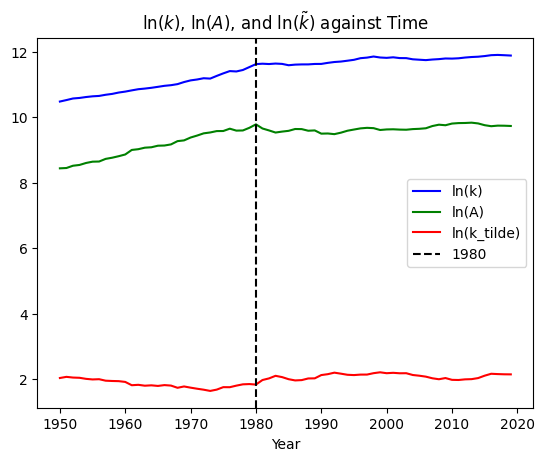

In [667]:
# Plot ln(k), ln(A), and ln(k_tilde) over time 
plt.plot(df_solow['year'], df_solow['logk'], label='ln(k)', color='blue')
plt.plot(df_solow['year'], df_solow['logA'], label='ln(A)', color='green')
plt.plot(df_solow['year'], np.log(df_solow['k_tilde']), label='ln(k_tilde)', color='red')
plt.axvline(x=1980, color='black', linestyle='--', label='1980')
plt.title(r"$\ln(k)$, $\ln(A)$, and $\ln(\tilde{k})$ against Time")
plt.xlabel('Year')
plt.legend()

# Save the plot
plt.savefig(os.path.join('plots', 'ln_k_A_k_tilde_labour_aug.png'), dpi=300, bbox_inches='tight')

plt.show()

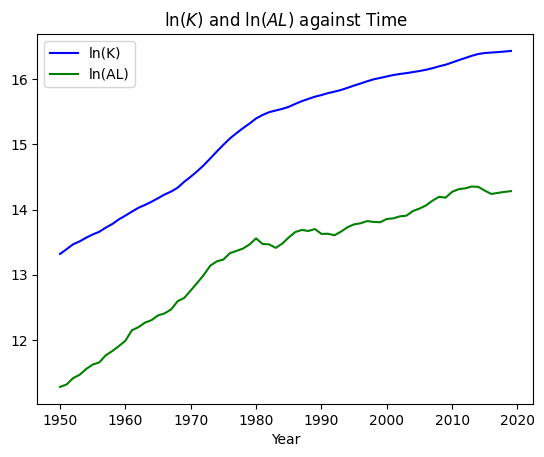

In [668]:
# Plot ln(K) and ln(AL) over time for the labour-augmenting production function
plt.plot(df_solow['year'], df_solow['logK'],label = 'ln(K)', color = 'blue')
plt.plot(df_solow['year'], np.log(df_solow['LA']), label = 'ln(AL)', color = 'green')
plt.xlabel('Year')
plt.title(r"$\ln(K)$ and $\ln(AL)$ against Time")
plt.legend()

# Save the plot
plt.savefig(os.path.join('plots', 'ln_K_LA.png'), dpi=300, bbox_inches='tight')

plt.show()

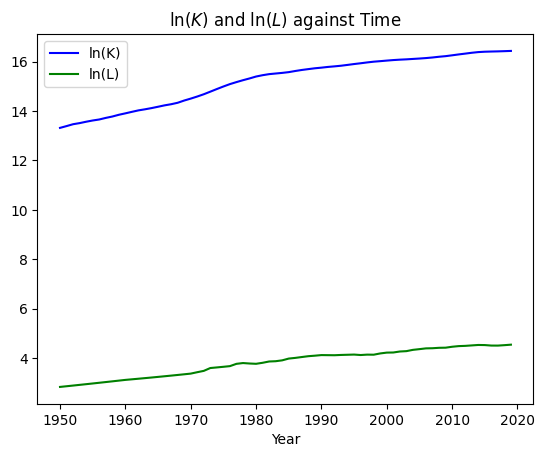

In [669]:
# Plot ln(K) and ln(L) over time 
plt.plot(df_solow['year'], df_solow['logK'],label = 'ln(K)', color = 'blue')
plt.plot(df_solow['year'], df_solow['logL'], label = 'ln(L)', color = 'green')
plt.xlabel('Year')
plt.title(r"$\ln(K)$ and $\ln(L)$ against Time")
plt.legend()

# Save the plot
plt.savefig(os.path.join('plots', 'ln_K_L.png'), dpi=300, bbox_inches='tight')

plt.show()

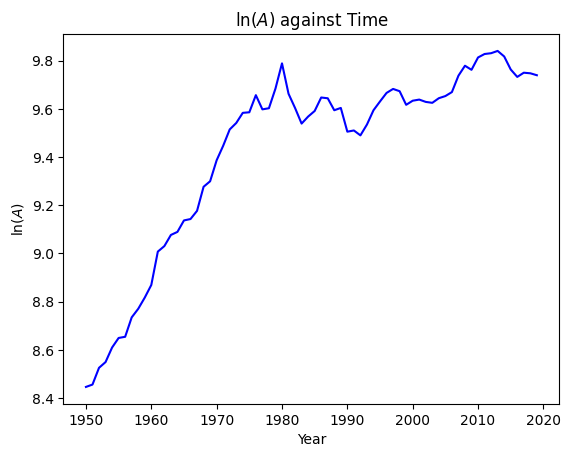

In [670]:
# Plot ln(A) against time
plt.plot(df_solow['year'], df_solow['logA'], color='blue')
plt.title(r"$\ln(A)$ against Time")
plt.xlabel('Year')
plt.ylabel(r'ln$(A)$')

# Save the plot
plt.savefig(os.path.join('plots', 'ln_A.png'), dpi=300, bbox_inches='tight')

plt.show()

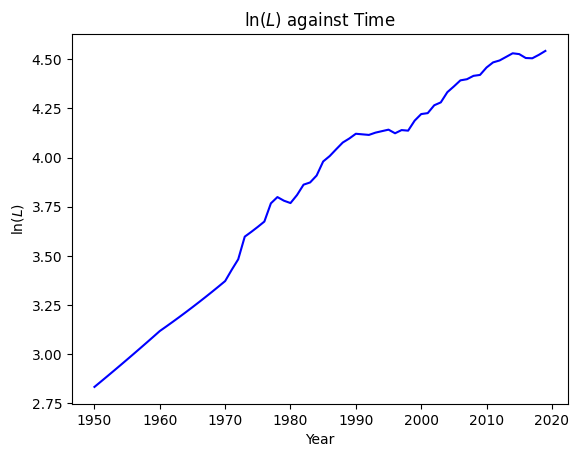

In [671]:
# Plot ln(L) against time
plt.plot(df_solow['year'], df_solow['logL'], color='blue')
plt.title(r"$\ln(L)$ against Time")
plt.xlabel('Year')
plt.ylabel(r'ln$(L)$')

# Save the plot
plt.savefig(os.path.join('plots', 'ln_L.png'), dpi=300, bbox_inches='tight')

plt.show()

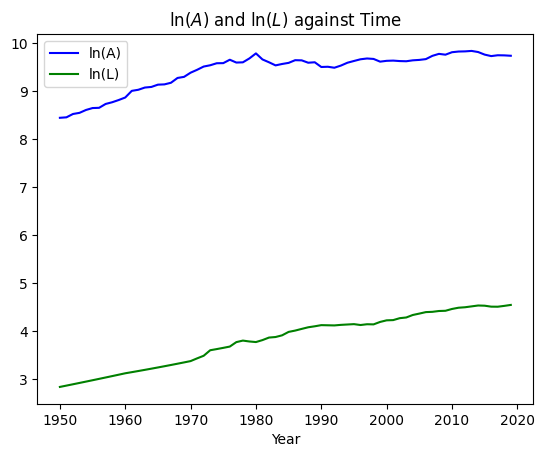

In [672]:
# Plot ln(A) and ln(L) together against time
plt.plot(df_solow['year'], df_solow['logA'], label='ln(A)', color='blue')
plt.plot(df_solow['year'], df_solow['logL'], label='ln(L)', color='green')
plt.title(r"$\ln(A)$ and $\ln(L)$ against Time")
plt.xlabel('Year')
plt.legend()

# Save the plot
plt.savefig(os.path.join('plots', 'ln_A_L.png'), dpi=300, bbox_inches='tight')

plt.show()

# 7. Romer Model  
Here, we will plot and compare trends in population and employed workers to confirm $s_R$, the fraction of workers doing R&D, is increasing.

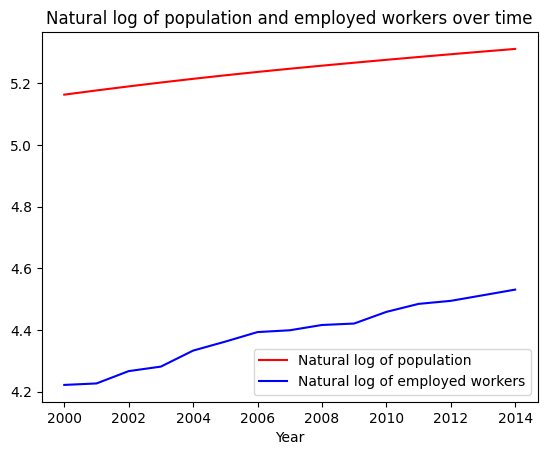

In [673]:
# We only look at the years 2000-2014
df_pop = df[(df['year'] >= 2000) & (df['year'] <= 2014)].copy()

plt.plot(df_pop['year'], np.log(df_pop['pop']), label = 'Natural log of population', color = 'red')
plt.plot(df_pop['year'], np.log(df_pop['emp']), label = 'Natural log of employed workers', color = 'blue')
plt.xlabel('Year')
plt.title('Natural log of population and employed workers over time')
plt.legend()

# Save the plot
plt.savefig(os.path.join('plots', 'ln_pop_emp.png'), dpi=300, bbox_inches='tight')

plt.show()

# 8. Export the manipulated dataframes to a single Excel file

In [674]:
with pd.ExcelWriter('Coursework_Chua_data.xlsx') as writer:
    df.to_excel(writer, sheet_name='Brazil (Full Dataset)', index=False)
    df3.to_excel(writer, sheet_name='Growth Accounting', index=False)
    df_solow.to_excel(writer, sheet_name='Solow Analysis', index=False)